# 데이터 준비

## Data fields

**targets**
- 'suicide' : 자살자 수(지역별/날짜별)

**features**

통계청 사망원인통계상 지역코드와 기상청 기후통계분석상 지역코드가 다름. 기후 관련 feature들의 지역코드는 기상청 기준으로, 그 외는 통계청 기준으로 맞춤.
- 'loc_num' : 통계청 <사망원인통계> 지역 코드, 17개(A형, 시도 기준)
- 'date' : 자살 통계 집계일(지역 기준)
- 'year' : 연도
- 'month' : 월 
- 'day' : 일
- 'weekday' : 요일
- 'loc_numm' : 기상청 <기후통계분석> 지역 코드, 9개
- 'loc_name' : 기상청 <기후통계분석> 지역명
- 'rain' : 일 평균 강우량(지역)
- 'temp' : 일 평균 기온(지역)
- 'hum' : 일 평균 습도(지역)
- 'sun' : 일 평균 일조량(지역)
- 'insola' : 일 평균 일사량(지역)
- 'exchange_rate' : 원/달러 환율(일)
- 'kospi' : 코스피지수 종가(일)
- 'price_index' : 소비자물가지수(월)
- 'house_debt' : 가계부채(월)
- 'patient' : 지역별 우울증 환자 수(월, 통계청 지역코드 기준) 
- 'unemployment' : 지역별 실업자 수(월, 통계청 지역코드 기준)

## 라이브러리 불러오기

In [3]:
!pip install eli5

  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107729 sha256=230ebb65f1f48e89be8c4d6e2fb38384342634e2894f3889bb5d42da6d2d1506
  Stored in directory: c:\users\82103\appdata\local\pip\cache\wheels\85\ac\25\ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
      Successfully uninstalled MarkupSafe-1.1.1
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
sphinx 4.0.1 requires Jinja2<3.0,>=2.3, but you have jinja2 3.1.2 which is incompatible.
sphinx 4.0.1 requires MarkupSafe<2.0, but you have markupsafe 2.1.1 which is incompatible.


In [5]:
!pip install shap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 4.0.1 requires Jinja2<3.0,>=2.3, but you have jinja2 3.1.2 which is incompatible.
sphinx 4.0.1 requires MarkupSafe<2.0, but you have markupsafe 2.1.1 which is incompatible.


In [626]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import eli5
import shap
import warnings
import xgboost

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from eli5.sklearn import PermutationImportance
from ipywidgets import interact, fixed
from scipy.stats import randint, uniform
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, plot_importance
# from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_interact_plot, pdp_plot

warnings.filterwarnings(action='ignore')

ModuleNotFoundError: No module named 'pdpbox'

In [357]:
plt.rc('font', family='NanumGothic') 

## 데이터 불러오기 + 분할

In [20]:
df = pd.read_csv('suicide.csv')
df

,loc_num,date,year,month,day,weekday,loc_numm,loc_name,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,unemployment,suicide
0,11.0,2011-01-01,2011.0,1.0,1.0,토,11.0,서울경기,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,NaN,252.0,6.0
1,21.0,2011-01-01,2011.0,1.0,1.0,토,38.0,경남,0.0,-2.0,46.0,6.1,9.85,1124.65,2051.00,88.288,806.4,NaN,64.0,2.0
2,22.0,2011-01-01,2011.0,1.0,1.0,토,37.0,경북,0.9,-3.3,55.0,3.7,8.44,1124.65,2051.00,88.288,806.4,NaN,51.0,1.0
3,23.0,2011-01-01,2011.0,1.0,1.0,토,11.0,서울경기,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,NaN,76.0,2.0
4,24.0,2011-01-01,2011.0,1.0,1.0,토,36.0,전남,0.4,-3.5,70.0,8.3,8.85,1124.65,2051.00,88.288,806.4,NaN,22.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46155,31.0,2020-12-31,2020.0,12.0,31.0,목,11.0,서울경기,0.0,-8.7,57.0,6.3,8.68,1084.47,2873.47,100.330,1631.5,80473.0,274.0,6.0
46156,33.0,2020-12-31,2020.0,12.0,31.0,목,33.0,충북,0.0,-9.4,63.0,6.1,11.02,1084.47,2873.47,100.330,1631.5,11591.0,26.0,1.0
46157,34.0,2020-12-31,2020.0,12.0,31.0,목,34.0,충남,0.4,-7.6,75.0,6.5,9.67,1084.47,2873.47,100.330,1631.5,15193.0,40.0,3.0
46158,37.0,2020-12-31,2020.0,12.0,31.0,목,37.0,경북,0.0,-6.6,48.0,8.7,11.22,1084.47,2873.47,100.330,1631.5,14348.0,57.0,2.0


In [28]:
df.columns

Index(['loc_num', 'date', 'year', 'month', 'day', 'weekday', 'loc_numm',
       'loc_name', 'rain', 'temp', 'hum', 'sun', 'insola', 'exchange_rate',
       'kospi', 'price_index', 'house_debt', 'patient', 'unemployment',
       'suicide'],
      dtype='object')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46160 entries, 0 to 46159
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc_num        46160 non-null  float64
 1   date           46160 non-null  object 
 2   year           46160 non-null  float64
 3   month          46160 non-null  float64
 4   day            46160 non-null  float64
 5   weekday        46160 non-null  object 
 6   loc_numm       46160 non-null  float64
 7   loc_name       46160 non-null  object 
 8   rain           46160 non-null  float64
 9   temp           46160 non-null  float64
 10  hum            46160 non-null  float64
 11  sun            46160 non-null  float64
 12  insola         46160 non-null  float64
 13  exchange_rate  46160 non-null  float64
 14  kospi          46160 non-null  float64
 15  price_index    46160 non-null  float64
 16  house_debt     46160 non-null  float64
 17  patient        36403 non-null  float64
 18  unempl

In [124]:
## 2011~2019년 train 데이터셋, 2020 test 데이터셋

train = df.loc[df.year < 2020]
test = df.loc[df.year > 2019]

train.shape, test.shape

((41601, 20), (4559, 20))

In [125]:
target = 'suicide'
features = ['loc_num', 'year', 'month', 'day', 'weekday', 
           'rain', 'temp', 'hum', 'sun', 'insola', 'exchange_rate',
           'kospi', 'price_index', 'house_debt', 'patient', 'unemployment']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((41601, 16), (41601,), (4559, 16), (4559,))

# 기준모델

In [670]:
baseline = [round(y_df.mean(),3)] * len(y_train)
print("기준 모델(평균) :",np.array(baseline))

기준 모델(평균) : [2.991 2.991 2.991 ... 2.991 2.991 2.991]


# randomforest

In [74]:
RandomForestRegressor

sklearn.ensemble._forest.RandomForestRegressor

In [79]:
pipe = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_jobs = -1, random_state = 42)
    )

pipe.fit(X_train, y_train)

pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)


0.5971989272779156

In [81]:
print(pipe.score(X_train, y_train))
print(r2_score(y_train, pred_train))
print(r2_score(y_test, pred_test))

0.9479578020129433
0.9479578020129433
0.5971989272779156


In [101]:
# pipe = make_pipeline(
#     OneHotEncoder(),
#     SimpleImputer(),
#     RandomForestRegressor(n_jobs = -1, random_state = 42)
# )

# dists = {
#     'randomforestregressor__max_depth' : [8, 10, 12, 14, 16],
#     'randomforestregressor__n_estimators' : [80, 100, 150, 200]
# }

# rand_cv = RandomizedSearchCV(
#     pipe,
#     param_distributions=dists,
#     n_iter = 500,
#     cv = 3,
#     scoring = 'accuracy',
#     verbose = 1,
#     random_state = 42
# )

# rand_cv.fit(X_train, y_train)

# rand_cv.best_params_
# rand_cv.best_score_
# scores_df = pd.DataFrame(rand_cv.cv_results_)
# print(scores_df)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

# 회귀모델에 적용

In [111]:
# def get_model_cv_prediction(model, X, y) : 
#     neg_mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv = 5)
#     rmse_scores = np.sqrt(-1 * neg_mse_scores)
#     avg_rmse = np.mean(rmse_scores)
#     print('###',model.__class__.__name__,'###')
#     print(' 5 교차 검증의 평균 RMSE:{0:.3f}'.format(avg_rmse))

In [170]:
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
xgb_reg = XGBRegressor()
lgb_reg = LGBMRegressor()

In [119]:
def model_score(model, X_train, y_train, X_test, y_test):
    ohe = OneHotEncoder()
    sim = SimpleImputer()
    
    X_train = ohe.fit_transform(X_train)
    X_train = sim.fit_transform(X_train)
    X_test = ohe.fit_transform(X_test)
    X_test = sim.fit_transform(X_test)
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    print('###',model.__class__.__name__,'###')
    print(r2_score(y_test, pred))

In [121]:
models = [ dt_reg, rf_reg, xgb_reg, lgb_reg ]

for model in models :
    model_score(model, X_train, y_train, X_test, y_test)

### DecisionTreeRegressor ###
0.6257497726992257


KeyboardInterrupt: 

In [139]:
pipe = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    XGBRegressor(n_estimator=1000, random_state=42, n_jobs = -1)
)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print('accuracy: ', pipe.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))

[21:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy:  0.7653638148005427
r2score:  0.5309371984799438


In [140]:
pipe = make_pipeline(
    OneHotEncoder(cols =['loc_num','year','month','day','weekday']),
    SimpleImputer(),
    XGBRegressor(n_estimator=1000, random_state=42, n_jobs = -1)
)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print('accuracy: ', pipe.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))

[21:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy:  0.7651652877385788
r2score:  0.5513079748188829


In [158]:
pipe = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LGBMRegressor(n_estimators=1000, random_state=42, n_jobs = -1))

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print('accuracy: ', pipe.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.8396000917885658
r2score:  0.5756166019471161
MAE: 1.1998945819390792
MSE:  2.6774636760869863
MSLE:  0.1456669598142627
RMSLE 0.3816634116787496


In [159]:
pipe2 = make_pipeline(
    OneHotEncoder(cols =['loc_num','year','month','day','weekday']),
    SimpleImputer(),
    LGBMRegressor(n_estimators=1000, random_state=42, n_jobs = -1))

pipe2.fit(X_train, y_train)
pred = pipe2.predict(X_test)

print('accuracy: ', pipe2.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.8345487084108074
r2score:  0.5885706384824037
MAE: 1.1860719258811798
MSE:  2.5957357799414957
MSLE:  0.1410396368537257
RMSLE 0.3755524422150996


In [151]:
pipe.named_steps['lgbmregressor']

LGBMRegressor(n_estimators=1000, random_state=42)

In [157]:
pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['weekday'])),
                ('simpleimputer', SimpleImputer()),
                ('lgbmregressor',
                 LGBMRegressor(n_estimators=1000, random_state=42))])

In [181]:
pipe2.named_steps

{'onehotencoder': OneHotEncoder(cols=['loc_num', 'year', 'month', 'day', 'weekday']),
 'simpleimputer': SimpleImputer(),
 'lgbmregressor': LGBMRegressor(n_estimators=1000, random_state=42)}

In [193]:
pipe = make_pipeline(
    OneHotEncoder(cols = ['loc_num','year','month','day','weekday']),
    SimpleImputer(),
    LGBMRegressor(n_estimator=1000, random_state=42, n_jobs = -1)
)


params = { 
    'lgbmregressor__n_estimators': [200, 500, 1000, 2000], 
    'lgbmregressor__learning_rate': [0.1, 0.05, 0.01], 
    'lgbmregressor__max_depth': [5, 10, 15, 20], 
    'lgbmregressor__colsample_bytree': [0.8, 0.9, 1.0],
    'lgbmregressor__subsample': [0.8, 0.9, 1.0] } 

clf = RandomizedSearchCV(
    pipe,
    params, 
    random_state=42, 
    cv=3,
    verbose=3,
    n_iter=20,
    scoring='r2'
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: n_estimator
[CV 1/3] END lgbmregressor__colsample_bytree=1.0, lgbmregressor__learning_rate=0.01, lgbmregressor__max_depth=20, lgbmregressor__n_estimators=500, lgbmregressor__subsample=0.9;, score=0.606 total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimator
[CV 2/3] END lgbmregressor__colsample_bytree=1.0, lgbmregressor__learning_rate=0.01, lgbmregressor__max_depth=20, lgbmregressor__n_estimators=500, lgbmregressor__subsample=0.9;, score=0.629 total time=   1.0s
[LightGBM] [Warning] Unknown parameter: n_estimator
[CV 3/3] END lgbmregressor__colsample_bytree=1.0, lgbmregressor__learning_rate=0.01, lgbmregressor__max_depth=20, lgbmregressor__n_estimators=500, lgbmregressor__subsample=0.9;, score=0.600 total time=   1.1s
[LightGBM] [Warning] Unknown parameter: n_estimator
[CV 1/3] END lgbmregressor__colsample_bytree=0.8, lgbmregressor__learning_rate=0.05, lgbmregressor__max_

[CV 2/3] END lgbmregressor__colsample_bytree=0.9, lgbmregressor__learning_rate=0.1, lgbmregressor__max_depth=5, lgbmregressor__n_estimators=2000, lgbmregressor__subsample=0.8;, score=0.586 total time=   2.4s
[LightGBM] [Warning] Unknown parameter: n_estimator
[CV 3/3] END lgbmregressor__colsample_bytree=0.9, lgbmregressor__learning_rate=0.1, lgbmregressor__max_depth=5, lgbmregressor__n_estimators=2000, lgbmregressor__subsample=0.8;, score=0.464 total time=   2.4s
[LightGBM] [Warning] Unknown parameter: n_estimator
[CV 1/3] END lgbmregressor__colsample_bytree=0.8, lgbmregressor__learning_rate=0.05, lgbmregressor__max_depth=10, lgbmregressor__n_estimators=2000, lgbmregressor__subsample=0.9;, score=0.566 total time=   2.5s
[LightGBM] [Warning] Unknown parameter: n_estimator
[CV 2/3] END lgbmregressor__colsample_bytree=0.8, lgbmregressor__learning_rate=0.05, lgbmregressor__max_depth=10, lgbmregressor__n_estimators=2000, lgbmregressor__subsample=0.9;, score=0.610 total time=   3.7s
[LightGB

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(cols=['loc_num',
                                                                  'year',
                                                                  'month',
                                                                  'day',
                                                                  'weekday'])),
                                             ('simpleimputer', SimpleImputer()),
                                             ('lgbmregressor',
                                              LGBMRegressor(n_estimator=1000,
                                                            random_state=42))]),
                   n_iter=20,
                   param_distributions={'lgbmregressor__colsample_bytree': [0.8,
                                                                            0.9,
                                                                            1.0],
                                        'lgbmregressor__learning_rate': [0.1,
                                                                         0.05,
                                                                         0.01],
                                        'lgbmregressor__max_depth': [5, 10, 15,
                                                                     20],
                                        'lgbmregressor__n_estimators': [200,
                                                                        500,
                                                                        1000,
                                                                        2000],
                                        'lgbmregressor__subsample': [0.8, 0.9,
                                                                     1.0]},
                   random_state=42, scoring='r2', verbose=3)

In [192]:
pipe.named_steps

{'onehotencoder': OneHotEncoder(cols=['loc_num', 'year', 'month', 'day', 'weekday']),
 'simpleimputer': SimpleImputer(),
 'lgbmregressor': LGBMRegressor(n_estimator=1000, random_state=42)}

In [197]:
print('best score: ', clf.best_score_)
print('best params: ', clf.best_params_)

best score:  0.6116079552105206
best params:  {'lgbmregressor__subsample': 0.9, 'lgbmregressor__n_estimators': 500, 'lgbmregressor__max_depth': 20, 'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__colsample_bytree': 1.0}


In [198]:
clf.best_

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(cols=['loc_num',
                                                                  'year',
                                                                  'month',
                                                                  'day',
                                                                  'weekday'])),
                                             ('simpleimputer', SimpleImputer()),
                                             ('lgbmregressor',
                                              LGBMRegressor(n_estimator=1000,
                                                            random_state=42))]),
                   n_iter=20,
                   param_distributions={'lgbmregressor__colsample_bytree': [0.8,
                                                                            0.9,
                                                                            1.0],
                                        'lgbmregressor__learning_rate': [0.1,
                                                                         0.05,
                                                                         0.01],
                                        'lgbmregressor__max_depth': [5, 10, 15,
                                                                     20],
                                        'lgbmregressor__n_estimators': [200,
                                                                        500,
                                                                        1000,
                                                                        2000],
                                        'lgbmregressor__subsample': [0.8, 0.9,
                                                                     1.0]},
                   random_state=42, scoring='r2', verbose=3)

In [199]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,0,19,17,6,4,5,1,2,8,12,15,14,9,11,3,16,18,13,7,10
mean_fit_time,0.982353,1.126963,0.608488,1.574946,1.393009,2.589036,0.845573,0.585292,0.839884,1.793608,0.977337,0.880068,0.793759,2.950564,1.391227,2.837675,1.954046,3.024428,2.097332,1.948245
std_fit_time,0.016016,0.082003,0.008276,0.013327,0.199735,0.123837,0.016072,0.005867,0.039162,0.109785,0.04835,0.029084,0.011996,0.545659,0.117829,0.219261,0.082683,0.608087,0.114119,0.060748
mean_score_time,0.18181,0.210329,0.141756,0.301073,0.292725,0.484137,0.17242,0.126115,0.228768,0.422576,0.198545,0.195908,0.206041,0.554128,0.271765,0.438846,0.545112,0.474568,0.566019,0.51083
std_score_time,0.008934,0.012743,0.003121,0.012963,0.018716,0.044225,0.003411,0.003623,0.025714,0.025005,0.021754,0.011803,0.011428,0.084306,0.014437,0.008333,0.012316,0.048121,0.023306,0.015042
param_lgbmregressor__subsample,0.9,0.9,0.8,0.8,1.0,1.0,0.8,0.8,0.8,0.9,1.0,0.8,0.9,0.9,0.8,0.9,0.8,0.9,0.9,0.8
param_lgbmregressor__n_estimators,500,500,200,1000,1000,2000,500,200,500,1000,500,500,500,2000,1000,2000,2000,2000,2000,2000
param_lgbmregressor__max_depth,20,20,15,15,5,15,15,20,5,5,15,20,5,10,15,20,5,20,5,5
param_lgbmregressor__learning_rate,0.01,0.01,0.05,0.01,0.01,0.01,0.05,0.1,0.05,0.05,0.1,0.1,0.1,0.05,0.1,0.05,0.1,0.1,0.1,0.1
param_lgbmregressor__colsample_bytree,1.0,0.9,0.8,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.9,0.8,0.9,0.8,0.8,1.0,0.8,1.0,0.9,0.9
params,"{'lgbmregressor__subsample': 0.9, 'lgbmregress...","{'lgbmregressor__subsample': 0.9, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress...","{'lgbmregressor__subsample': 1.0, 'lgbmregress...","{'lgbmregressor__subsample': 1.0, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress...","{'lgbmregressor__subsample': 0.9, 'lgbmregress...","{'lgbmregressor__subsample': 1.0, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress...","{'lgbmregressor__subsample': 0.9, 'lgbmregress...","{'lgbmregressor__subsample': 0.9, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress...","{'lgbmregressor__subsample': 0.9, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress...","{'lgbmregressor__subsample': 0.9, 'lgbmregress...","{'lgbmregressor__subsample': 0.9, 'lgbmregress...","{'lgbmregressor__subsample': 0.8, 'lgbmregress..."


In [203]:
pipe_best = make_pipeline(
    OneHotEncoder(cols = ['loc_num','year','month','day','weekday']),
    SimpleImputer(),
    LGBMRegressor(
    n_estimators=500, 
    subsample=0.9, 
    max_depth=20, 
    learning_rate=0.01, 
    colsample_bytree=1)
)

pred = pipe_best.fit(X_train, y_train).predict(X_test)

print('accuracy: ', pipe_best.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.682490148318714
r2score:  0.6432095874775285
MAE: 1.10975459068954
MSE:  2.251014940471272
MSLE:  0.1243014612186076
RMSLE 0.35256412355571237


튜닝 전
- accuracy:  0.8345487084108074
- r2score:  0.5885706384824037
- MAE: 1.1860719258811798
- MSE:  2.5957357799414957
- MSLE:  0.1410396368537257
- RMSLE 0.3755524422150996

튜닝 후
- accuracy:  0.682490148318714
- r2score:  0.6432095874775285
- MAE: 1.10975459068954
- MSE:  2.251014940471272
- MSLE:  0.1243014612186076
- RMSLE 0.35256412355571237

# feature engeering ver1


In [268]:
target = 'suicide'
features = ['loc_num', 'year', 'month', 'day', 'weekday', 
           'rain', 'temp', 'hum', 'sun', 'insola', 'exchange_rate',
           'kospi', 'price_index', 'house_debt', 'patient', 'unemployment']

X_df = df[features]
y_df = df[target]

X_df.shape, y_df.shape

((46160, 16), (46160,))

In [ ]:
def engeeniring(df):
    df = pd.get_dummies(df, columns = ['loc_num','year','month','day','weekday'])
    df.patient.fillna(df.patient.mean(), inplace=True)
    return df

In [270]:
X_df = engeeniring(X_df)
X_df

,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,...,day_29.0,day_30.0,day_31.0,weekday_금,weekday_목,weekday_수,weekday_월,weekday_일,weekday_토,weekday_화
0,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
1,0.0,-2.0,46.0,6.1,9.85,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
2,0.9,-3.3,55.0,3.7,8.44,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
3,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
4,0.4,-3.5,70.0,8.3,8.85,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46155,0.0,-8.7,57.0,6.3,8.68,1084.47,2873.47,100.330,1631.5,80473.000000,...,0,0,1,0,1,0,0,0,0,0
46156,0.0,-9.4,63.0,6.1,11.02,1084.47,2873.47,100.330,1631.5,11591.000000,...,0,0,1,0,1,0,0,0,0,0
46157,0.4,-7.6,75.0,6.5,9.67,1084.47,2873.47,100.330,1631.5,15193.000000,...,0,0,1,0,1,0,0,0,0,0
46158,0.0,-6.6,48.0,8.7,11.22,1084.47,2873.47,100.330,1631.5,14348.000000,...,0,0,1,0,1,0,0,0,0,0


In [272]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=47 )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32312, 88), (13848, 88), (32312,), (13848,))

In [275]:
params = { 
    'n_estimators': [200, 500, 1000, 2000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [5, 10, 15, 20], 
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0] 
} 

reg = RandomizedSearchCV(
    LGBMRegressor(n_jobs = -1),
    params, 
    random_state=42,
    cv=5,
    verbose=3,
    n_iter=100,
    scoring='r2'
)

reg.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.9;, score=0.646 total time=   0.7s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.9;, score=0.647 total time=   0.7s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.9;, score=0.639 total time=   0.6s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.9;, score=0.645 total time=   0.6s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.9;, score=0.640 total time=   0.7s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, n_estimators=500, subsample=0.8;, score=0.638 total time=   0.5s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, n_estimators=500, subsample=0.8;, score=0.644 total time=   0.5s

[CV 2/5] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.636 total time=   1.3s
[CV 3/5] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.633 total time=   1.1s
[CV 4/5] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.625 total time=   1.1s
[CV 5/5] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.633 total time=   1.2s
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=0.9;, score=0.579 total time=   2.6s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=0.9;, score=0.584 total time=   2.7s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=0.9;, score=0.582 total time=   2.4s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.1, max_dept

[CV 4/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.9;, score=0.635 total time=   0.3s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.9;, score=0.636 total time=   0.2s
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=1.0;, score=0.579 total time=   2.3s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=1.0;, score=0.584 total time=   2.3s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=1.0;, score=0.582 total time=   2.2s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=1.0;, score=0.575 total time=   2.2s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=1.0;, score=0.589 total time=   2.1s
[CV 1/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=

[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=1000, subsample=1.0;, score=0.646 total time=   1.4s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=1000, subsample=1.0;, score=0.648 total time=   1.4s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=1000, subsample=1.0;, score=0.640 total time=   1.3s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=1000, subsample=1.0;, score=0.644 total time=   1.3s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=1000, subsample=1.0;, score=0.641 total time=   1.3s
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=15, n_estimators=2000, subsample=0.9;, score=0.580 total time=   2.3s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=15, n_estimators=2000, subsample=0.9;, score=0.581 total time=   2.3s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.1, max

[CV 3/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=20, n_estimators=1000, subsample=0.9;, score=0.626 total time=   1.2s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=20, n_estimators=1000, subsample=0.9;, score=0.623 total time=   1.1s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=20, n_estimators=1000, subsample=0.9;, score=0.630 total time=   1.1s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8;, score=0.624 total time=   0.6s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8;, score=0.628 total time=   0.6s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8;, score=0.623 total time=   0.5s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8;, score=0.619 total time=   0.5s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth

[CV 5/5] END colsample_bytree=0.9, learning_rate=0.01, max_depth=20, n_estimators=1000, subsample=1.0;, score=0.641 total time=   1.3s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, n_estimators=1000, subsample=0.9;, score=0.627 total time=   1.1s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, n_estimators=1000, subsample=0.9;, score=0.633 total time=   1.2s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, n_estimators=1000, subsample=0.9;, score=0.630 total time=   1.1s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, n_estimators=1000, subsample=0.9;, score=0.627 total time=   1.1s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, n_estimators=1000, subsample=0.9;, score=0.629 total time=   1.1s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=20, n_estimators=1000, subsample=0.8;, score=0.625 total time=   1.2s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, 

[CV 2/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.8;, score=0.647 total time=   0.8s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.8;, score=0.639 total time=   0.7s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.8;, score=0.645 total time=   0.7s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, n_estimators=500, subsample=0.8;, score=0.640 total time=   0.9s
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.8;, score=0.633 total time=   1.0s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.8;, score=0.635 total time=   1.0s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.8;, score=0.629 total time=   1.0s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.05, max_dep

[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=1000, subsample=0.8;, score=0.624 total time=   1.1s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=1000, subsample=0.8;, score=0.629 total time=   1.1s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=200, subsample=0.8;, score=0.630 total time=   0.3s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=200, subsample=0.8;, score=0.628 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=200, subsample=0.8;, score=0.627 total time=   0.3s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=200, subsample=0.8;, score=0.629 total time=   0.3s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=20, n_estimators=200, subsample=0.8;, score=0.627 total time=   0.3s
[CV 1/5] END colsample_bytree=0.9, learning_rate=0.05, max_d

[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=0.8;, score=0.578 total time=   2.2s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=0.8;, score=0.585 total time=   2.3s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=0.8;, score=0.581 total time=   2.1s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=0.8;, score=0.577 total time=   2.1s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, n_estimators=2000, subsample=0.8;, score=0.590 total time=   2.1s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.1, 0.05, 0.01],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [200, 500, 1000, 2000],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='r2', verbose=3)

In [288]:
pred = reg.predict(X_test)

print('accuracy: ', reg.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.6872619111917391
r2score:  0.6466849499473813
MAE: 1.1266792701906474
MSE:  2.448322985598981
MSLE:  0.12108134228772621
RMSLE 0.347967444292891


In [406]:
pred = reg2.predict(X_test)

print('accuracy: ', reg2.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.6726390732088952
r2score:  0.6467778915766035
MAE: 1.1267490335773613
MSE:  2.447678939648746
MSLE:  0.1211006451249315
RMSLE 0.347995179743817


In [274]:
print('best score: ', reg.best_score_)
print('best params: ', reg.best_params_)

best score:  0.6442013314670332
best params:  {'subsample': 1.0, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [285]:
print('best score: ', reg2.best_score_)
print('best params: ', reg2.best_params_)

best score:  0.6458703570887531
best params:  {'subsample': 0.8, 'n_estimators': 1200, 'max_depth': 4, 'colsample_bytree': 0.8}


In [320]:
params = { 
    'n_estimators': [800, 1000, 1200], 
    'max_depth': [4, 5, 6, 7, 8, 9], 
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0] 
} 

reg2 = RandomizedSearchCV(
    LGBMRegressor(learning_rate = 0.01, n_jobs = -1),
    params, 
    random_state=42,
    cv=3,
    verbose=3,
    n_iter=100,
    scoring='r2'
)

reg2.fit(X_train, y_train)
print('best score: ', reg2.best_score_)
print('best params: ', reg2.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END colsample_bytree=1.0, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.648 total time=   1.3s
[CV 2/3] END colsample_bytree=1.0, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.643 total time=   1.4s
[CV 3/3] END colsample_bytree=1.0, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.634 total time=   1.3s
[CV 1/3] END colsample_bytree=1.0, max_depth=4, n_estimators=800, subsample=0.9;, score=0.652 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, max_depth=4, n_estimators=800, subsample=0.9;, score=0.644 total time=   0.6s
[CV 3/3] END colsample_bytree=1.0, max_depth=4, n_estimators=800, subsample=0.9;, score=0.639 total time=   0.6s
[CV 1/3] END colsample_bytree=1.0, max_depth=6, n_estimators=1000, subsample=1.0;, score=0.649 total time=   1.2s
[CV 2/3] END colsample_bytree=1.0, max_depth=6, n_estimators=1000, subsample=1.0;, score=0.644 total time=   1.2s
[CV 3/3] END colsample_bytre

[CV 1/3] END colsample_bytree=0.8, max_depth=7, n_estimators=1000, subsample=0.9;, score=0.650 total time=   1.4s
[CV 2/3] END colsample_bytree=0.8, max_depth=7, n_estimators=1000, subsample=0.9;, score=0.644 total time=   1.4s
[CV 3/3] END colsample_bytree=0.8, max_depth=7, n_estimators=1000, subsample=0.9;, score=0.636 total time=   1.4s
[CV 1/3] END colsample_bytree=1.0, max_depth=9, n_estimators=800, subsample=0.8;, score=0.649 total time=   1.3s
[CV 2/3] END colsample_bytree=1.0, max_depth=9, n_estimators=800, subsample=0.8;, score=0.644 total time=   1.2s
[CV 3/3] END colsample_bytree=1.0, max_depth=9, n_estimators=800, subsample=0.8;, score=0.635 total time=   1.2s
[CV 1/3] END colsample_bytree=0.9, max_depth=8, n_estimators=1200, subsample=0.9;, score=0.648 total time=   1.7s
[CV 2/3] END colsample_bytree=0.9, max_depth=8, n_estimators=1200, subsample=0.9;, score=0.643 total time=   1.8s
[CV 3/3] END colsample_bytree=0.9, max_depth=8, n_estimators=1200, subsample=0.9;, score=0.

[CV 2/3] END colsample_bytree=1.0, max_depth=8, n_estimators=800, subsample=0.9;, score=0.644 total time=   1.3s
[CV 3/3] END colsample_bytree=1.0, max_depth=8, n_estimators=800, subsample=0.9;, score=0.635 total time=   1.3s
[CV 1/3] END colsample_bytree=0.9, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.651 total time=   1.2s
[CV 2/3] END colsample_bytree=0.9, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.645 total time=   1.2s
[CV 3/3] END colsample_bytree=0.9, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.637 total time=   1.3s
[CV 1/3] END colsample_bytree=1.0, max_depth=4, n_estimators=1200, subsample=0.9;, score=0.652 total time=   1.2s
[CV 2/3] END colsample_bytree=1.0, max_depth=4, n_estimators=1200, subsample=0.9;, score=0.645 total time=   0.9s
[CV 3/3] END colsample_bytree=1.0, max_depth=4, n_estimators=1200, subsample=0.9;, score=0.639 total time=   1.2s
[CV 1/3] END colsample_bytree=0.8, max_depth=5, n_estimators=800, subsample=1.0;, score=0.

[CV 3/3] END colsample_bytree=0.9, max_depth=5, n_estimators=800, subsample=0.9;, score=0.638 total time=   0.9s
[CV 1/3] END colsample_bytree=0.8, max_depth=8, n_estimators=1200, subsample=1.0;, score=0.649 total time=   1.7s
[CV 2/3] END colsample_bytree=0.8, max_depth=8, n_estimators=1200, subsample=1.0;, score=0.644 total time=   1.9s
[CV 3/3] END colsample_bytree=0.8, max_depth=8, n_estimators=1200, subsample=1.0;, score=0.635 total time=   1.7s
[CV 1/3] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.648 total time=   1.5s
[CV 2/3] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.643 total time=   1.5s
[CV 3/3] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.636 total time=   1.5s
[CV 1/3] END colsample_bytree=0.8, max_depth=7, n_estimators=800, subsample=0.9;, score=0.650 total time=   1.3s
[CV 2/3] END colsample_bytree=0.8, max_depth=7, n_estimators=800, subsample=0.9;, score=0.

[CV 1/3] END colsample_bytree=1.0, max_depth=8, n_estimators=1200, subsample=0.8;, score=0.648 total time=   1.8s
[CV 2/3] END colsample_bytree=1.0, max_depth=8, n_estimators=1200, subsample=0.8;, score=0.643 total time=   1.7s
[CV 3/3] END colsample_bytree=1.0, max_depth=8, n_estimators=1200, subsample=0.8;, score=0.634 total time=   2.0s
[CV 1/3] END colsample_bytree=1.0, max_depth=9, n_estimators=800, subsample=1.0;, score=0.649 total time=   1.8s
[CV 2/3] END colsample_bytree=1.0, max_depth=9, n_estimators=800, subsample=1.0;, score=0.644 total time=   1.9s
[CV 3/3] END colsample_bytree=1.0, max_depth=9, n_estimators=800, subsample=1.0;, score=0.635 total time=   2.0s
[CV 1/3] END colsample_bytree=0.8, max_depth=9, n_estimators=1200, subsample=1.0;, score=0.649 total time=   1.9s
[CV 2/3] END colsample_bytree=0.8, max_depth=9, n_estimators=1200, subsample=1.0;, score=0.643 total time=   1.6s
[CV 3/3] END colsample_bytree=0.8, max_depth=9, n_estimators=1200, subsample=1.0;, score=0.

In [321]:
print('accuracy: ', reg2.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.6726390732088952
r2score:  0.6462173415034489
MAE: 1.1266778242266233
MSE:  2.451563313180185
MSLE:  0.121140844760724
RMSLE 0.34805293384875235


In [294]:
params = { 
    'boosting_type' : ['gbdt','rf'],
    'num_leaves': [None, 40, 50, 60],
    'max_depth':[4, 5, 8, 10],
    'reg_alpha': [None, 5, 10]
} 

reg3 = RandomizedSearchCV(
    LGBMRegressor(subsample=0.8, n_estimators=1200, learning_rate = 0.01, colsample_bytree = 0.8, n_jobs = -1),
    params, 
    random_state=42,
    cv=3,
    verbose=3,
    n_iter=100,
    scoring='r2'
)

reg3.fit(X_train, y_train)

print('best score: ', reg3.best_score_)
print('best params: ', reg3.best_params_)

pred = reg3.predict(X_test)



Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, reg_alpha=None;, score=0.653 total time=   0.8s
[CV 2/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, reg_alpha=None;, score=0.645 total time=   0.9s
[CV 3/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, reg_alpha=None;, score=0.639 total time=   0.8s
[CV 1/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, reg_alpha=5;, score=0.654 total time=   1.0s
[CV 2/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, reg_alpha=5;, score=0.645 total time=   1.0s
[CV 3/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, reg_alpha=5;, score=0.640 total time=   1.2s
[CV 1/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, reg_alpha=10;, score=0.654 total time=   1.0s
[CV 2/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, reg_alpha=10;, score=0.646 total time=   0.9s
[CV 3/3] END boosting_type=gbdt, max_depth=4, num_leaves=None, 

[CV 2/3] END boosting_type=gbdt, max_depth=8, num_leaves=None, reg_alpha=5;, score=0.644 total time=   2.0s
[CV 3/3] END boosting_type=gbdt, max_depth=8, num_leaves=None, reg_alpha=5;, score=0.636 total time=   2.0s
[CV 1/3] END boosting_type=gbdt, max_depth=8, num_leaves=None, reg_alpha=10;, score=0.651 total time=   2.0s
[CV 2/3] END boosting_type=gbdt, max_depth=8, num_leaves=None, reg_alpha=10;, score=0.645 total time=   2.3s
[CV 3/3] END boosting_type=gbdt, max_depth=8, num_leaves=None, reg_alpha=10;, score=0.637 total time=   2.1s
[CV 1/3] END boosting_type=gbdt, max_depth=8, num_leaves=40, reg_alpha=None;, score=0.647 total time=   1.9s
[CV 2/3] END boosting_type=gbdt, max_depth=8, num_leaves=40, reg_alpha=None;, score=0.642 total time=   1.9s
[CV 3/3] END boosting_type=gbdt, max_depth=8, num_leaves=40, reg_alpha=None;, score=0.634 total time=   1.9s
[CV 1/3] END boosting_type=gbdt, max_depth=8, num_leaves=40, reg_alpha=5;, score=0.649 total time=   2.2s
[CV 2/3] END boosting_ty

[CV 3/3] END boosting_type=rf, max_depth=4, num_leaves=None, reg_alpha=10;, score=nan total time=   0.0s
[CV 1/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha=None;, score=nan total time=   0.0s
[CV 2/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha=None;, score=nan total time=   0.0s
[CV 3/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha=None;, score=nan total time=   0.0s
[CV 1/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha=5;, score=nan total time=   0.0s
[CV 2/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha=5;, score=nan total time=   0.0s
[CV 3/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha=5;, score=nan total time=   0.0s
[CV 1/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha=10;, score=nan total time=   0.0s
[CV 2/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha=10;, score=nan total time=   0.0s
[CV 3/3] END boosting_type=rf, max_depth=4, num_leaves=40, reg_alpha

[CV 3/3] END boosting_type=rf, max_depth=8, num_leaves=40, reg_alpha=10;, score=nan total time=   0.0s
[CV 1/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=None;, score=nan total time=   0.0s
[CV 2/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=None;, score=nan total time=   0.0s
[CV 3/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=None;, score=nan total time=   0.0s
[CV 1/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=5;, score=nan total time=   0.0s
[CV 2/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=5;, score=nan total time=   0.0s
[CV 3/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=5;, score=nan total time=   0.0s
[CV 1/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=10;, score=nan total time=   0.0s
[CV 2/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=10;, score=nan total time=   0.0s
[CV 3/3] END boosting_type=rf, max_depth=8, num_leaves=50, reg_alpha=1

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [298]:
print('accuracy: ', reg3.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.6716764899830658
r2score:  0.6462173415034489
MAE: 1.1266778242266233
MSE:  2.451563313180185
MSLE:  0.121140844760724
RMSLE 0.34805293384875235


In [297]:
params = { 
    'reg_alpha': [None, 5 , 7, 9, 10],
    'reg_lambda' : [None, 5, 7, 9, 10]
} 

reg4 = RandomizedSearchCV(
    LGBMRegressor(boosting_type = 'gbdt', subsample=0.8, n_estimators=1200, max_depth=4, learning_rate = 0.01, colsample_bytree = 0.8, n_jobs = -1),
    params, 
    random_state=42,
    cv=5,
    verbose=3,
    n_iter=100,
    scoring='r2'
)

reg4.fit(X_train, y_train)

print('best score: ', reg4.best_score_)
print('best params: ', reg4.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...reg_alpha=None, reg_lambda=None;, score=0.649 total time=   0.8s
[CV 2/5] END ...reg_alpha=None, reg_lambda=None;, score=0.652 total time=   0.9s
[CV 3/5] END ...reg_alpha=None, reg_lambda=None;, score=0.642 total time=   0.8s
[CV 4/5] END ...reg_alpha=None, reg_lambda=None;, score=0.645 total time=   0.9s
[CV 5/5] END ...reg_alpha=None, reg_lambda=None;, score=0.644 total time=   0.8s
[CV 1/5] END ......reg_alpha=None, reg_lambda=5;, score=0.649 total time=   0.9s
[CV 2/5] END ......reg_alpha=None, reg_lambda=5;, score=0.652 total time=   0.9s
[CV 3/5] END ......reg_alpha=None, reg_lambda=5;, score=0.642 total time=   0.8s
[CV 4/5] END ......reg_alpha=None, reg_lambda=5;, score=0.645 total time=   0.9s
[CV 5/5] END ......reg_alpha=None, reg_lambda=5;, score=0.643 total time=   0.9s
[CV 1/5] END ......reg_alpha=None, reg_lambda=7;, score=0.649 total time=   0.9s
[CV 2/5] END ......reg_alpha=None, reg_lambda=7

[CV 2/5] END .....reg_alpha=10, reg_lambda=None;, score=0.652 total time=   1.1s
[CV 3/5] END .....reg_alpha=10, reg_lambda=None;, score=0.643 total time=   1.1s
[CV 4/5] END .....reg_alpha=10, reg_lambda=None;, score=0.646 total time=   1.0s
[CV 5/5] END .....reg_alpha=10, reg_lambda=None;, score=0.644 total time=   1.1s
[CV 1/5] END ........reg_alpha=10, reg_lambda=5;, score=0.650 total time=   1.2s
[CV 2/5] END ........reg_alpha=10, reg_lambda=5;, score=0.652 total time=   1.2s
[CV 3/5] END ........reg_alpha=10, reg_lambda=5;, score=0.643 total time=   1.2s
[CV 4/5] END ........reg_alpha=10, reg_lambda=5;, score=0.646 total time=   1.2s
[CV 5/5] END ........reg_alpha=10, reg_lambda=5;, score=0.644 total time=   1.2s
[CV 1/5] END ........reg_alpha=10, reg_lambda=7;, score=0.649 total time=   1.2s
[CV 2/5] END ........reg_alpha=10, reg_lambda=7;, score=0.652 total time=   1.2s
[CV 3/5] END ........reg_alpha=10, reg_lambda=7;, score=0.643 total time=   1.2s
[CV 4/5] END ........reg_alp

In [299]:
pred = reg4.predict(X_test)

print('accuracy: ', reg4.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.6693058045922333
r2score:  0.6462173415034489
MAE: 1.1266778242266233
MSE:  2.451563313180185
MSLE:  0.121140844760724
RMSLE 0.34805293384875235


In [300]:
import eli5
from eli5.sklearn import PermutationImportance

In [302]:
perm = PermutationImportance(reg4, random_state = 1).fit(X_test, y_test)
eli5.show.weights(perm, feature_names = X_test.columns.tolist())

AttributeError: module 'eli5' has no attribute 'show'

In [319]:
reg3.best_estimator_

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=4,
              n_estimators=1200, num_leaves=None, reg_alpha=5, subsample=0.8)

In [407]:
best_lgbm = LGBMRegressor(
    colsample_bytree=0.8, 
    learning_rate=0.01, 
    max_depth=4, 
    n_estimators=1200,
    num_leaves=None,
    reg_alpha=10,
    subsample=0.8,
    random_state = 42
)

best_lgbm.fit(X_train, y_train)

pred = best_lgbm.predict(X_test)

print('accuracy: ', best_lgbm.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.6705267929801902
r2score:  0.6466280899925907
MAE: 1.126469188834634
MSE:  2.4487170008956785
MSLE:  0.12112064318609253
RMSLE 0.3480239118021814


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

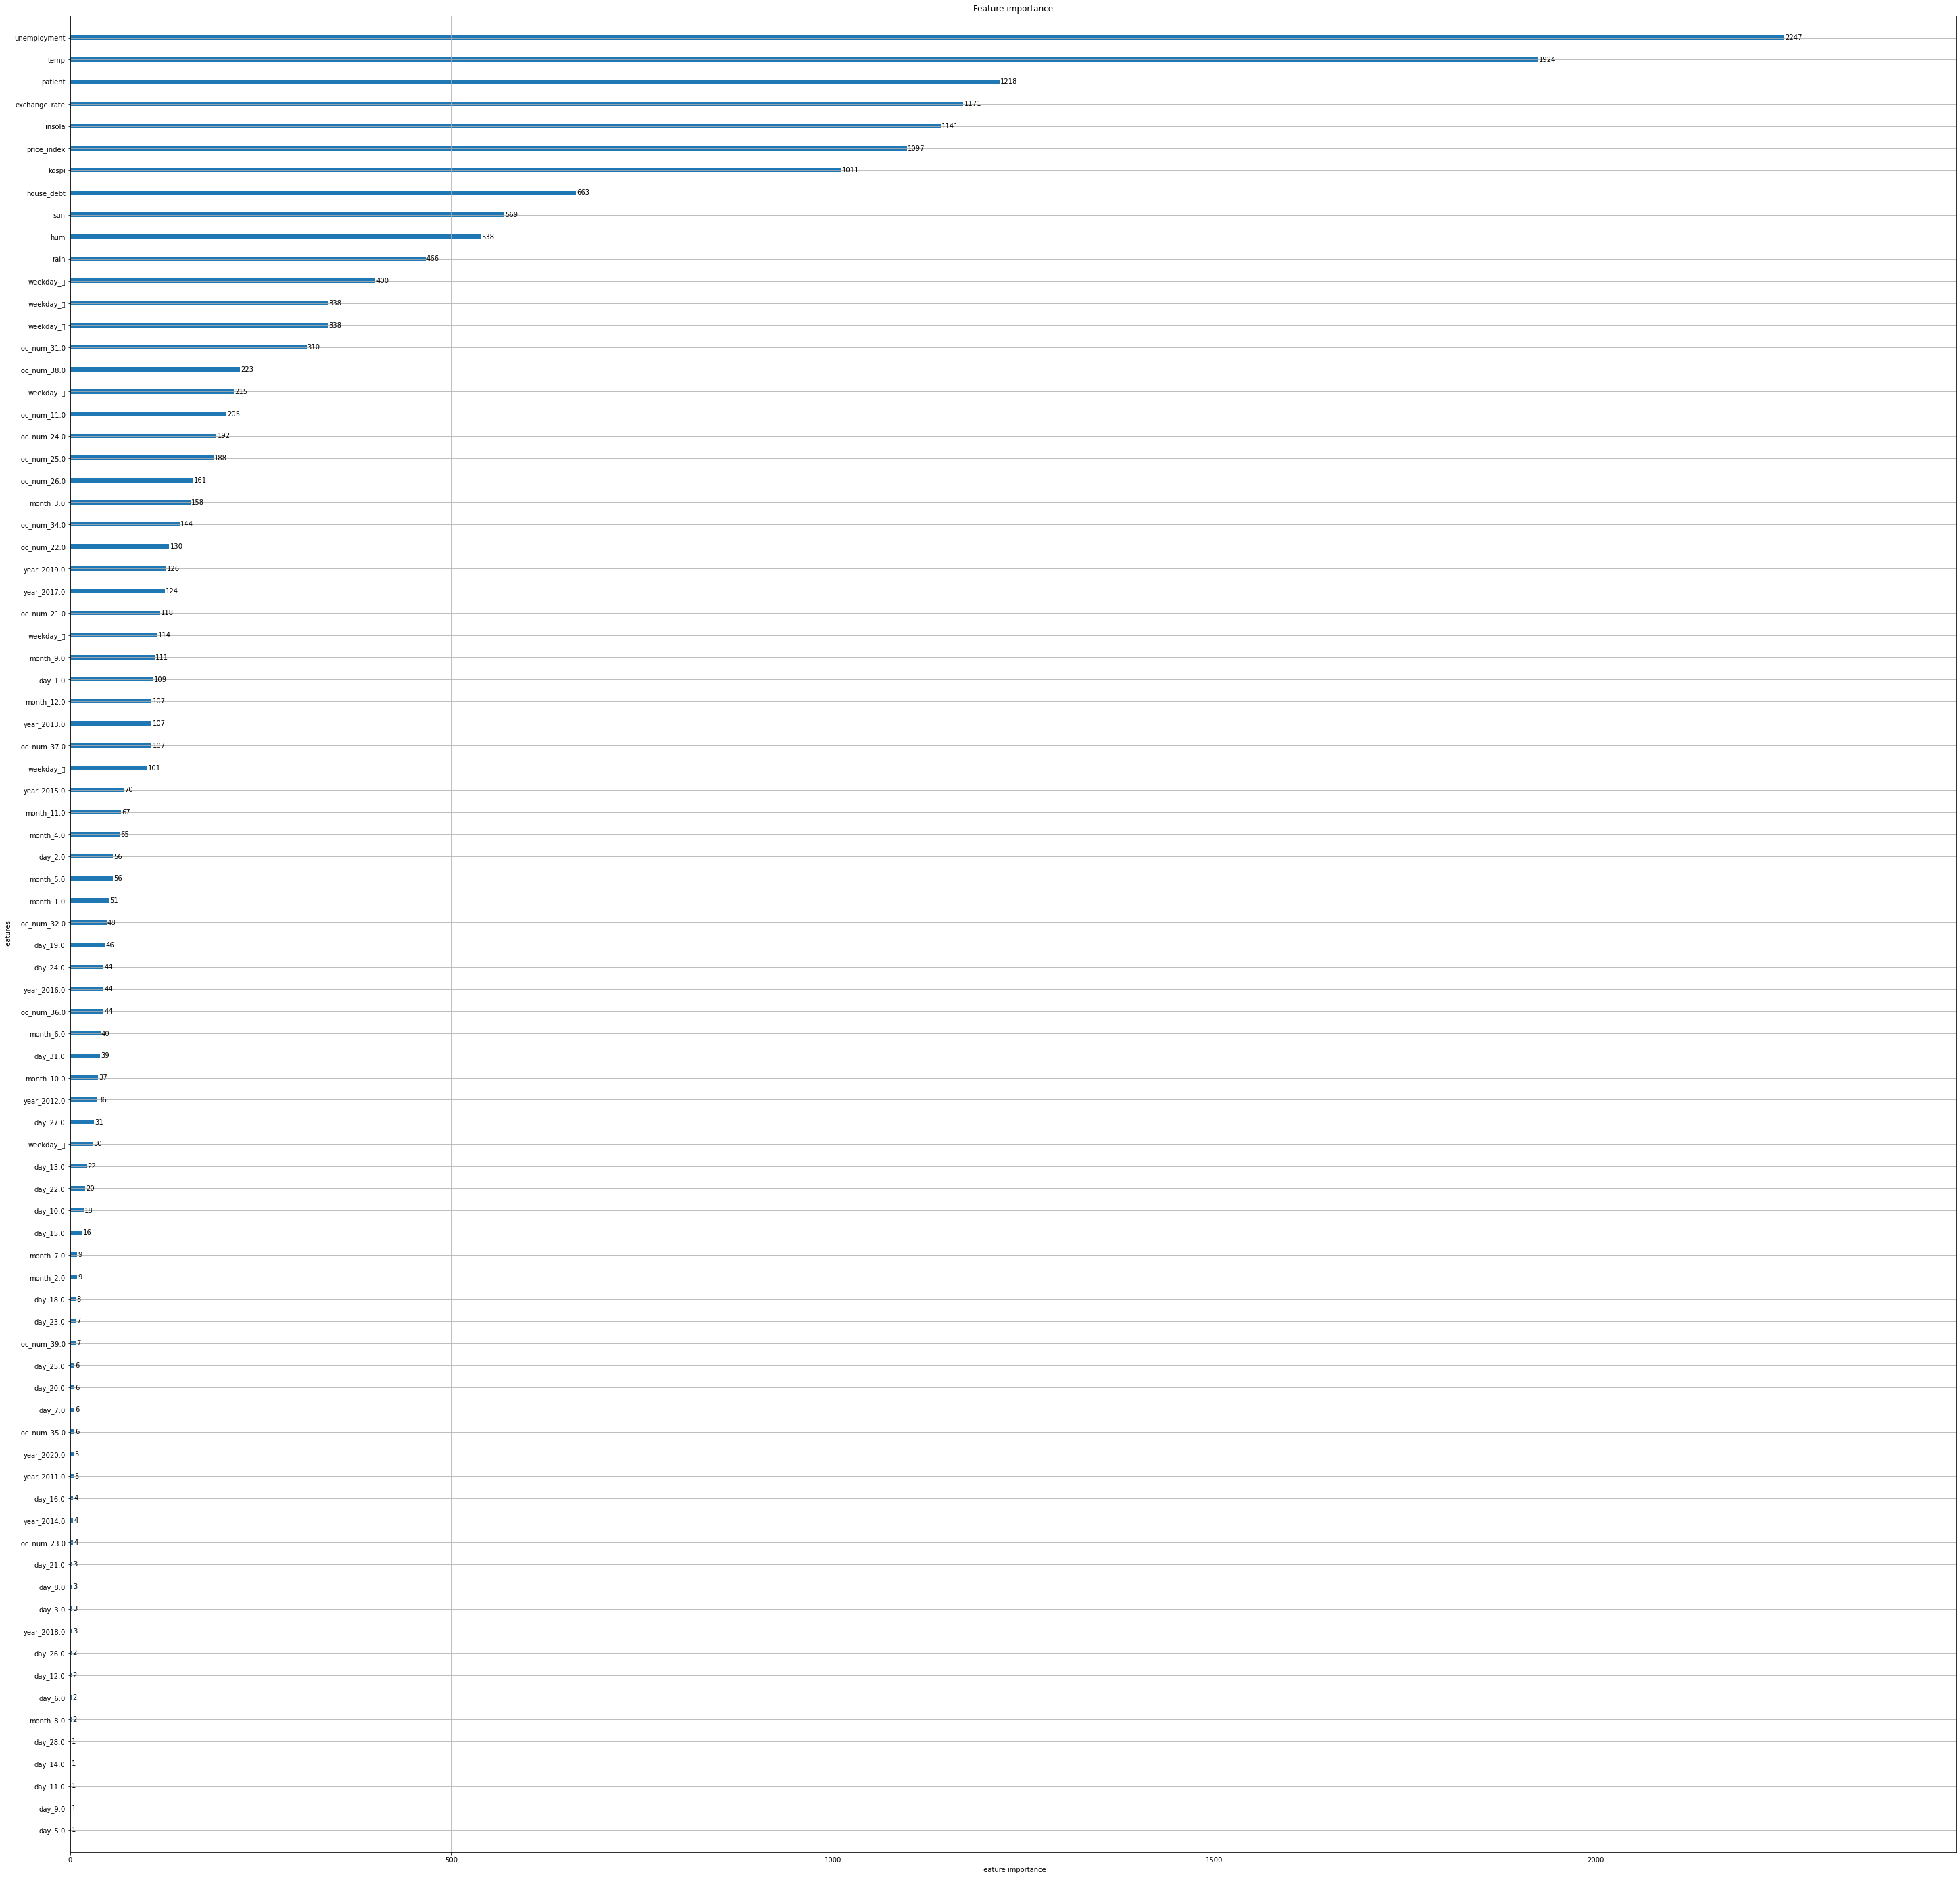

In [327]:
fig, ax = plt.subplots(figsize=(50,50))

plot_importance(best_lgbm, ax = ax)

In [324]:
permuter = PermutationImportance(
    best_lgbm,
    scoring='r2',
    n_iter=5, 
    random_state=2)

In [336]:
# X_test = pipe.named_steps['simpleimputer'].transform(X_test)
permuter.fit(X_test, y_test);

In [337]:
feature_names = X_df.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

unemployment     8.142871e-01
loc_num_31.0     5.381067e-02
loc_num_11.0     1.365958e-02
temp             9.597021e-03
house_debt       7.473121e-03
weekday_토        6.556358e-03
patient          6.466051e-03
weekday_월        5.562383e-03
price_index      5.270880e-03
insola           3.687741e-03
loc_num_38.0     3.608672e-03
weekday_일        3.224057e-03
exchange_rate    2.589378e-03
weekday_화        1.870373e-03
loc_num_24.0     1.366623e-03
loc_num_25.0     1.304084e-03
loc_num_26.0     1.242553e-03
month_3.0        1.215870e-03
loc_num_21.0     8.825525e-04
weekday_수        8.279933e-04
loc_num_34.0     8.247357e-04
loc_num_37.0     6.944295e-04
kospi            5.801127e-04
loc_num_22.0     4.654282e-04
month_12.0       4.351361e-04
rain             3.953721e-04
year_2017.0      3.312840e-04
day_1.0          2.980572e-04
month_5.0        2.428285e-04
month_9.0        2.080861e-04
sun              2.074442e-04
year_2019.0      1.691978e-04
year_2013.0      1.588108e-04
year_2016.

# feature engeeniring ver2
- 날짜 관련 feature들 제거 뒤 모델링

In [364]:
target = 'suicide'
features = ['loc_num', 'weekday', 'rain', 'temp', 'hum', 'sun', 'insola', 'exchange_rate','kospi', 'price_index', 'house_debt', 'patient', 'unemployment']

X_df2 = df[features]
y_df2 = df[target]

X_df2.shape, y_df2.shape

((46160, 13), (46160,))

In [366]:
def engeeniring(df):
    df = pd.get_dummies(df, columns = ['loc_num', 'weekday'])
    df.patient.fillna(df.patient.mean(), inplace=True)
    return df

In [367]:
X_df2 = engeeniring(X_df2)
X_df2

,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,...,loc_num_37.0,loc_num_38.0,loc_num_39.0,weekday_금,weekday_목,weekday_수,weekday_월,weekday_일,weekday_토,weekday_화
0,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
1,0.0,-2.0,46.0,6.1,9.85,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
2,0.9,-3.3,55.0,3.7,8.44,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
3,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
4,0.4,-3.5,70.0,8.3,8.85,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46155,0.0,-8.7,57.0,6.3,8.68,1084.47,2873.47,100.330,1631.5,80473.000000,...,0,0,0,0,1,0,0,0,0,0
46156,0.0,-9.4,63.0,6.1,11.02,1084.47,2873.47,100.330,1631.5,11591.000000,...,0,0,0,0,1,0,0,0,0,0
46157,0.4,-7.6,75.0,6.5,9.67,1084.47,2873.47,100.330,1631.5,15193.000000,...,0,0,0,0,1,0,0,0,0,0
46158,0.0,-6.6,48.0,8.7,11.22,1084.47,2873.47,100.330,1631.5,14348.000000,...,1,0,0,0,1,0,0,0,0,0


In [368]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_df2, y_df2, test_size=0.3, random_state=47 )
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((32312, 35), (13848, 35), (32312,), (13848,))

In [369]:
params = { 
    'n_estimators': [800, 1000, 1200], 
    'max_depth': [4, 5, 6, 7, 8, 9], 
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [None, 5 , 7, 9, 10],
    'reg_lambda' : [None, 5, 7, 9, 10]
} 

reg_ = RandomizedSearchCV(
    LGBMRegressor(learning_rate = 0.01, n_jobs = -1),
    params, 
    random_state=42,
    cv=5,
    verbose=3,
    n_iter=100,
    scoring='r2'
)

reg_.fit(X_train2, y_train2)
pred2 = reg_.predict(X_test2)


print('best score: ', reg_.best_score_)
print('best params: ', reg_.best_params_)

print('accuracy: ', reg_.score(X_train2, y_train2))
print('r2score: ',r2_score(y_test2, pred2))
print('MAE:',mean_absolute_error(y_test2, pred2))
print('MSE: ',mean_squared_error(y_test2, pred2))
print('MSLE: ',mean_squared_log_error(y_test2, pred2))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test2, pred2)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.649 total time=   0.8s
[CV 2/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.651 total time=   0.9s
[CV 3/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.643 total time=   0.7s
[CV 4/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.645 total time=   0.7s
[CV 5/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.642 total time=   0.7s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=1000, reg_alpha=10, reg_lambda=10, subsample=1.0;, score=0.649 total time=   0.7s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=1000, reg_alpha=10, reg_lamb

[CV 3/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.641 total time=   1.2s
[CV 4/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.644 total time=   1.2s
[CV 5/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.639 total time=   1.3s
[CV 1/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.646 total time=   1.5s
[CV 2/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.652 total time=   1.4s
[CV 3/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.641 total time=   1.5s
[CV 4/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.644 total time=   1.4s
[CV 5/5] END cols

[CV 1/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.645 total time=   1.2s
[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.652 total time=   1.2s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.642 total time=   1.1s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.645 total time=   1.2s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.639 total time=   1.2s
[CV 1/5] END colsample_bytree=1.0, max_depth=5, n_estimators=800, reg_alpha=9, reg_lambda=9, subsample=1.0;, score=0.646 total time=   1.1s
[CV 2/5] END colsample_bytree=1.0, max_depth=5, n_estimators=800, reg_alpha=9, reg_lambda=9, subsample=1.0;, score=0.652 total time=   1.0s
[CV 3/5] END colsamp

[CV 4/5] END colsample_bytree=1.0, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.644 total time=   1.3s
[CV 5/5] END colsample_bytree=1.0, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.639 total time=   1.3s
[CV 1/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.645 total time=   1.5s
[CV 2/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.650 total time=   1.7s
[CV 3/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.640 total time=   1.5s
[CV 4/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.643 total time=   1.5s
[CV 5/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.639 total time=   1.6s


[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.650 total time=   1.5s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.641 total time=   1.5s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.642 total time=   1.5s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.638 total time=   1.5s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.649 total time=   0.7s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.651 total time=   0.7s
[CV 3/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.643 total time=   0.7s
[CV 

[CV 5/5] END colsample_bytree=1.0, max_depth=8, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.639 total time=   1.3s
[CV 1/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.644 total time=   1.8s
[CV 2/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.651 total time=   1.8s
[CV 3/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.642 total time=   1.8s
[CV 4/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.643 total time=   1.8s
[CV 5/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.638 total time=   1.8s
[CV 1/5] END colsample_bytree=1.0, max_depth=8, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.9;, score=0.644 total time=   1.4s
[CV 2/5] END co

[CV 3/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.640 total time=   1.2s
[CV 4/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.643 total time=   1.2s
[CV 5/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.639 total time=   1.2s
[CV 1/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.649 total time=   0.7s
[CV 2/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.650 total time=   0.7s
[CV 3/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.643 total time=   0.7s
[CV 4/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.645 total time=   0.7s

[CV 1/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.643 total time=   1.9s
[CV 2/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.650 total time=   2.1s
[CV 3/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.640 total time=   1.9s
[CV 4/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.642 total time=   2.0s
[CV 5/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.637 total time=   1.8s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=10, reg_lambda=9, subsample=0.9;, score=0.649 total time=   0.7s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=10, reg_lambda=9, subsample=0.9;, score=0.650 total time=   0.8s
[CV 3/5] END 

[CV 4/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.645 total time=   0.9s
[CV 5/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.642 total time=   0.9s
[CV 1/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.645 total time=   1.6s
[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.652 total time=   1.5s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.641 total time=   1.8s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.644 total time=   1.5s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.640 total time=   1.5s
[CV 1/5]

In [370]:
reg_.best_estimator_

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=4,
              n_estimators=1000, reg_alpha=7, reg_lambda=5, subsample=0.9)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

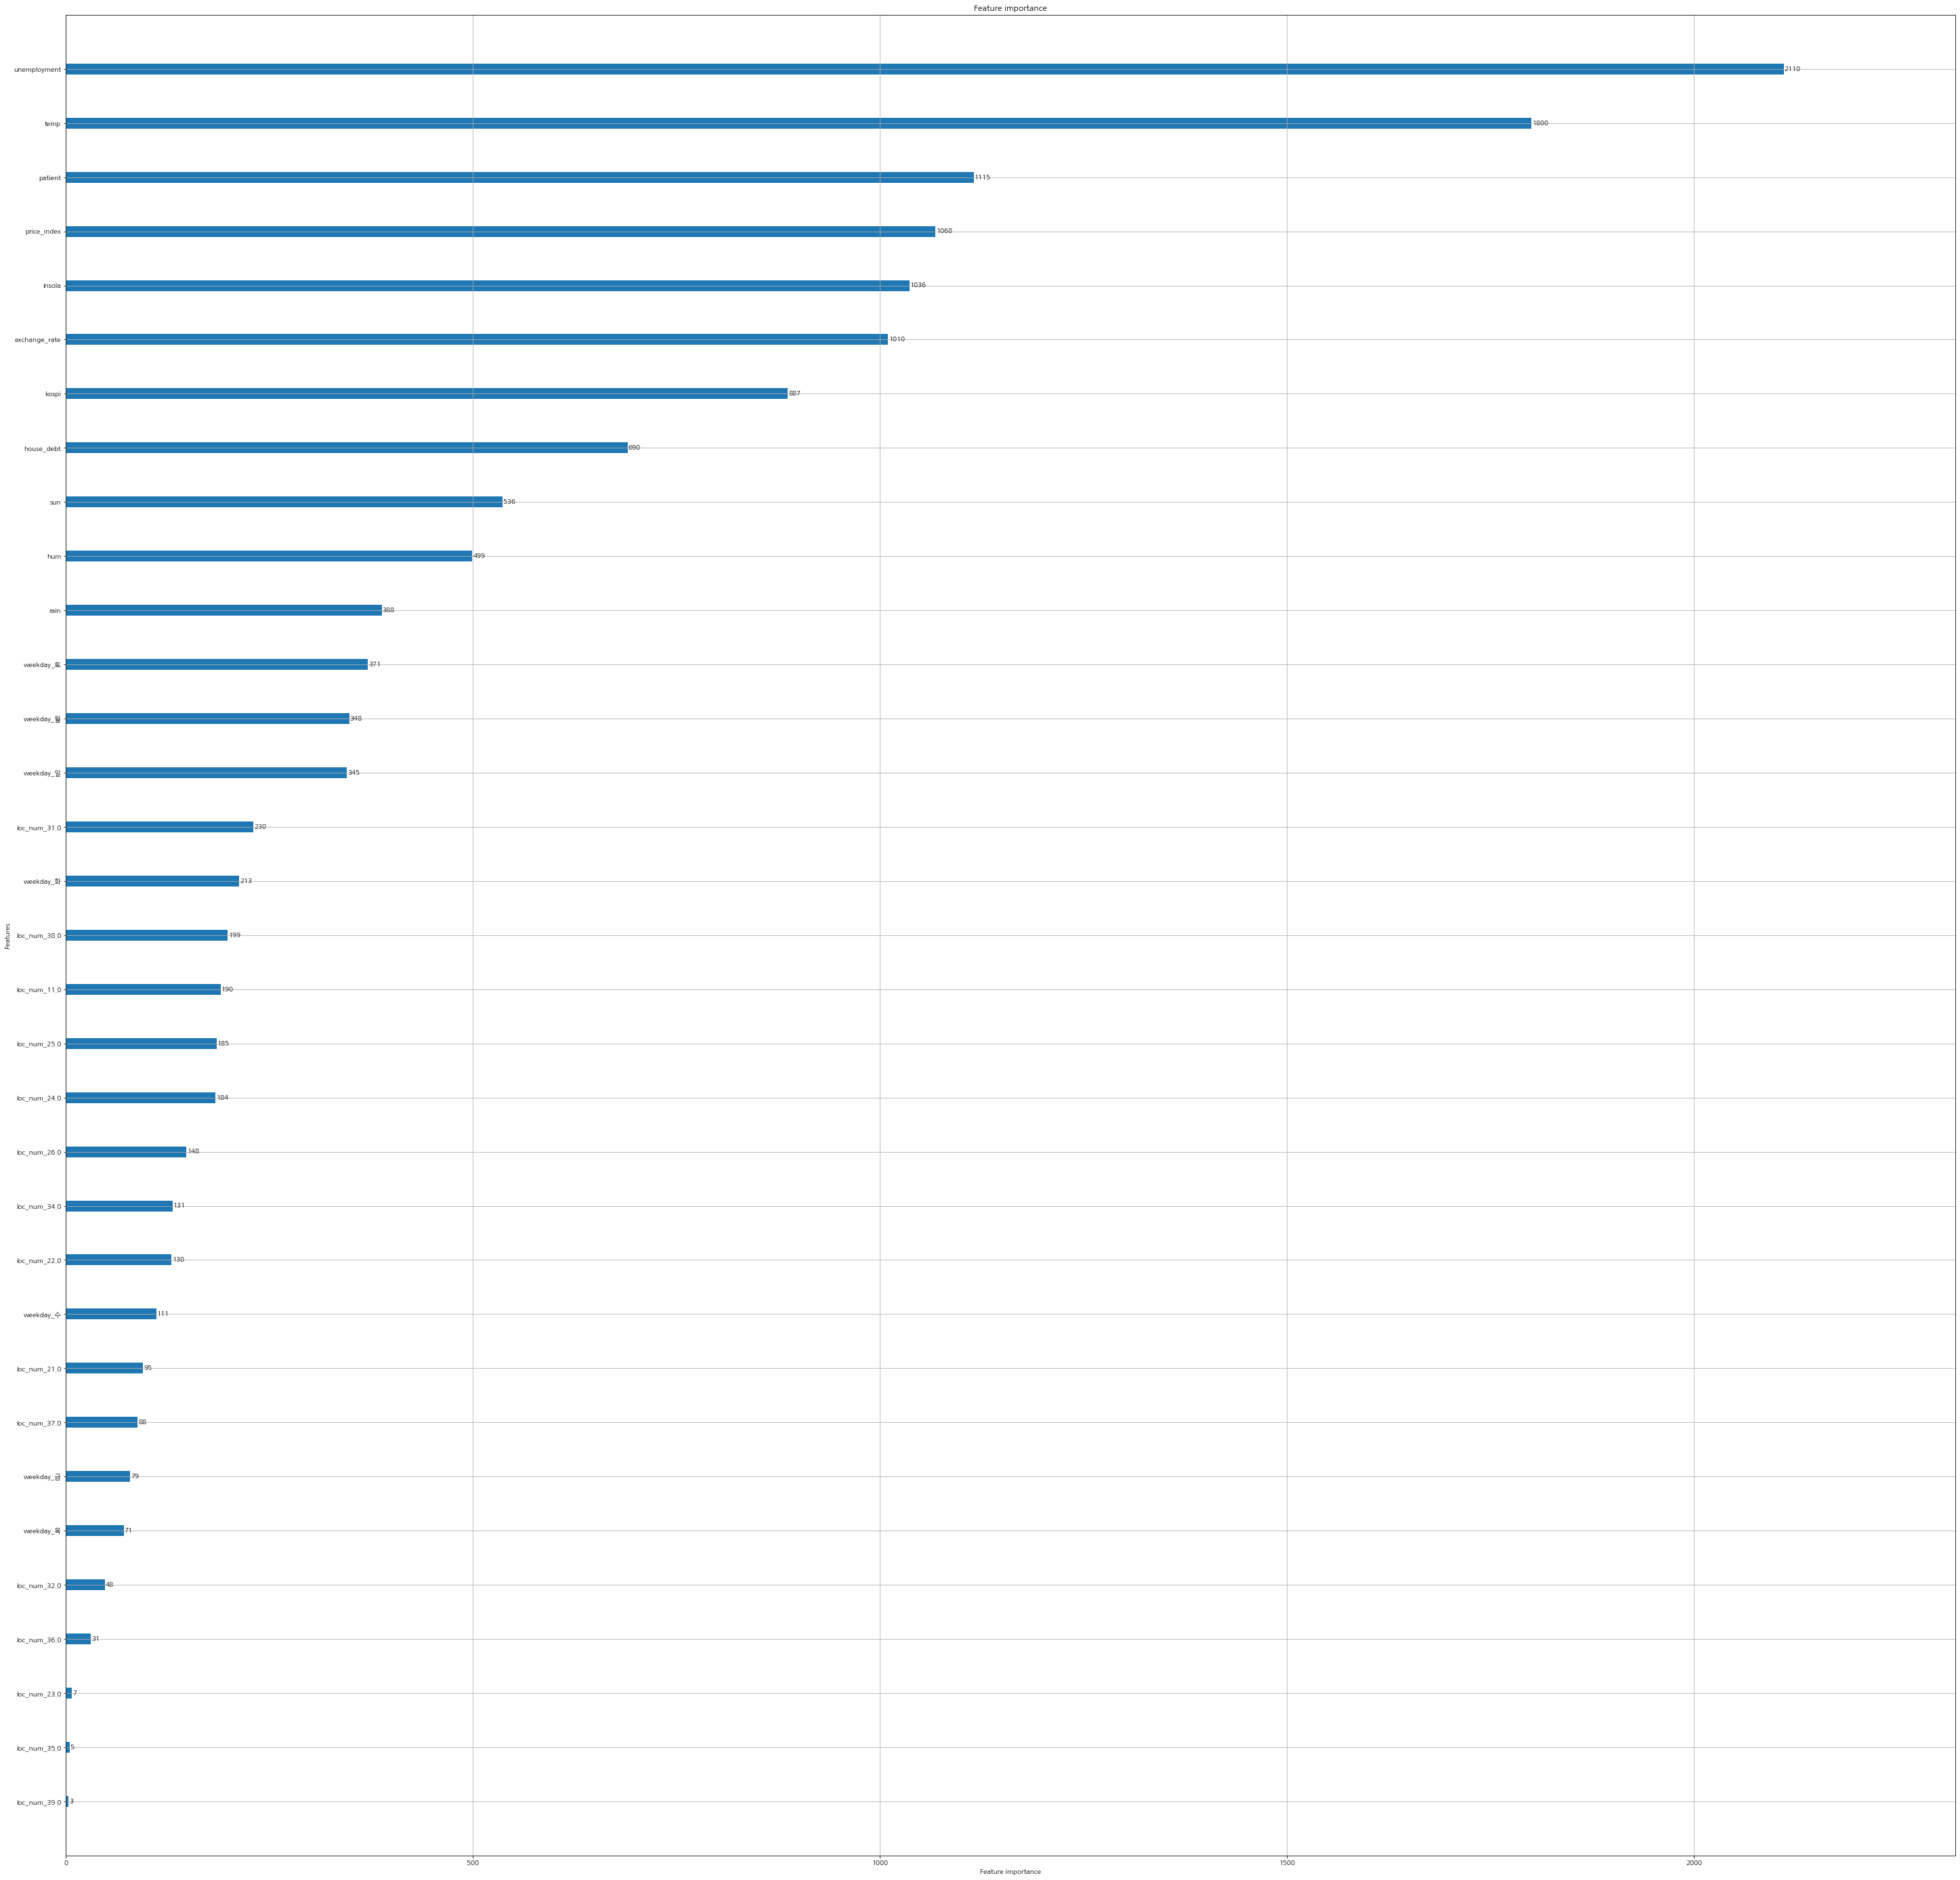

In [371]:
fig, ax = plt.subplots(figsize=(50,50))
plot_importance(reg_.best_estimator_, ax = ax)

In [379]:
permuter = PermutationImportance(
    reg_.best_estimator_,
    scoring='r2',
    n_iter=5, 
    random_state=2)

perm = permuter.fit(X_test2, y_test2)

In [383]:
eli5.show_weights(perm, top = 20, feature_names = X_test2.columns.to_list())

Weight,Feature
1.0210 ± 0.0232,unemployment
0.0244 ± 0.0027,loc_num_31.0
0.0201 ± 0.0009,loc_num_11.0
0.0115 ± 0.0013,temp
0.0075 ± 0.0013,house_debt
0.0065 ± 0.0014,weekday_토
0.0058 ± 0.0020,insola
0.0051 ± 0.0019,price_index
0.0051 ± 0.0020,weekday_월
0.0045 ± 0.0004,patient


In [377]:
pd.Series(permuter.feature_importances_, X_df2.columns).sort_values(ascending=False)

unemployment     1.021005
loc_num_31.0     0.024376
loc_num_11.0     0.020084
temp             0.011462
house_debt       0.007532
weekday_토        0.006461
insola           0.005755
price_index      0.005146
weekday_월        0.005053
patient          0.004506
loc_num_38.0     0.003278
exchange_rate    0.002955
weekday_일        0.002910
weekday_화        0.002292
loc_num_25.0     0.001421
loc_num_26.0     0.001331
loc_num_24.0     0.001226
loc_num_21.0     0.000811
loc_num_34.0     0.000648
kospi            0.000594
loc_num_37.0     0.000549
weekday_수        0.000421
loc_num_22.0     0.000412
rain             0.000252
sun              0.000108
hum              0.000077
loc_num_32.0     0.000024
loc_num_36.0     0.000024
weekday_금        0.000022
loc_num_39.0     0.000010
weekday_목        0.000004
loc_num_23.0     0.000003
loc_num_35.0     0.000002
loc_num_33.0     0.000000
loc_num_29.0     0.000000
dtype: float64

In [374]:
ft_importance_values = reg_.best_estimator_.feature_importances_
pd.Series(ft_importance_values, index = X_train2.columns).sort_values(ascending = False)

unemployment     2110
temp             1800
patient          1115
price_index      1068
insola           1036
exchange_rate    1010
kospi             887
house_debt        690
sun               536
hum               499
rain              388
weekday_토         371
weekday_월         348
weekday_일         345
loc_num_31.0      230
weekday_화         213
loc_num_38.0      199
loc_num_11.0      190
loc_num_25.0      185
loc_num_24.0      184
loc_num_26.0      148
loc_num_34.0      131
loc_num_22.0      130
weekday_수         111
loc_num_21.0       95
loc_num_37.0       88
weekday_금          79
weekday_목          71
loc_num_32.0       48
loc_num_36.0       31
loc_num_23.0        7
loc_num_35.0        5
loc_num_39.0        3
loc_num_33.0        0
loc_num_29.0        0
dtype: int32

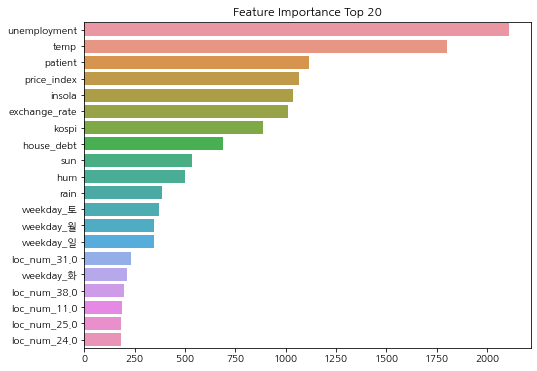

In [375]:
ft_importance_values = reg_.best_estimator_.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환

ft_series = pd.Series(ft_importance_values, index = X_train2.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)

plt.show()

# feature engeering ver3

In [384]:
target = 'suicide'
features = ['loc_num', 'month', 'weekday', 'rain', 'temp', 'hum', 'sun', 'insola', 'exchange_rate','kospi', 'price_index', 'house_debt', 'patient', 'unemployment']

X_df3 = df[features]
y_df3 = df[target]

X_df3.shape, y_df3.shape

((46160, 14), (46160,))

In [385]:
def engeeniring(df):
    df = pd.get_dummies(df, columns = ['loc_num', 'weekday', 'month'])
    df.patient.fillna(df.patient.mean(), inplace=True)
    return df

In [386]:
X_df3 = engeeniring(X_df3)
X_df3

,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,...,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
0,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,0,0
1,0.0,-2.0,46.0,6.1,9.85,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,0,0
2,0.9,-3.3,55.0,3.7,8.44,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,0,0
3,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,0,0
4,0.4,-3.5,70.0,8.3,8.85,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46155,0.0,-8.7,57.0,6.3,8.68,1084.47,2873.47,100.330,1631.5,80473.000000,...,0,0,0,0,0,0,0,0,0,1
46156,0.0,-9.4,63.0,6.1,11.02,1084.47,2873.47,100.330,1631.5,11591.000000,...,0,0,0,0,0,0,0,0,0,1
46157,0.4,-7.6,75.0,6.5,9.67,1084.47,2873.47,100.330,1631.5,15193.000000,...,0,0,0,0,0,0,0,0,0,1
46158,0.0,-6.6,48.0,8.7,11.22,1084.47,2873.47,100.330,1631.5,14348.000000,...,0,0,0,0,0,0,0,0,0,1


In [404]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_df3, y_df3, test_size=0.3, random_state=47 )
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((32312, 47), (13848, 47), (32312,), (13848,))

In [405]:
params = { 
    'n_estimators': [800, 1000, 1200], 
    'max_depth': [4, 5, 6, 7, 8, 9], 
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [None, 5 , 7, 9, 10],
    'reg_lambda' : [None, 5, 7, 9, 10]
} 

reg3 = RandomizedSearchCV(
    LGBMRegressor(learning_rate = 0.01, n_jobs = -1),
    params, 
    random_state=42,
    cv=5,
    verbose=3,
    n_iter=100,
    scoring='r2'
)

reg3.fit(X_train3, y_train3)
pred3 = reg_.predict(X_test3)


print('best score: ', reg3.best_score_)
print('best params: ', reg3.best_params_)

print('accuracy: ', reg3.score(X_train3, y_train3))
print('r2score: ',r2_score(y_test3, pred3))
print('MAE:',mean_absolute_error(y_test3, pred3))
print('MSE: ',mean_squared_error(y_test3, pred3))
print('MSLE: ',mean_squared_log_error(y_test3, pred3))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test3, pred3)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.650 total time=   0.8s
[CV 2/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.651 total time=   0.9s
[CV 3/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.643 total time=   0.9s
[CV 4/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.645 total time=   0.8s
[CV 5/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.642 total time=   0.9s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=1000, reg_alpha=10, reg_lambda=10, subsample=1.0;, score=0.650 total time=   0.8s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=1000, reg_alpha=10, reg_lamb

[CV 3/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.640 total time=   1.5s
[CV 4/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.644 total time=   1.5s
[CV 5/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.640 total time=   1.4s
[CV 1/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.647 total time=   1.5s
[CV 2/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.652 total time=   1.4s
[CV 3/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.640 total time=   1.5s
[CV 4/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.645 total time=   1.4s
[CV 5/5] END cols

[CV 1/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.647 total time=   1.3s
[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.651 total time=   1.3s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.641 total time=   1.3s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.645 total time=   1.4s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.640 total time=   1.3s
[CV 1/5] END colsample_bytree=1.0, max_depth=5, n_estimators=800, reg_alpha=9, reg_lambda=9, subsample=1.0;, score=0.647 total time=   1.2s
[CV 2/5] END colsample_bytree=1.0, max_depth=5, n_estimators=800, reg_alpha=9, reg_lambda=9, subsample=1.0;, score=0.651 total time=   1.2s
[CV 3/5] END colsamp

[CV 4/5] END colsample_bytree=1.0, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.644 total time=   1.5s
[CV 5/5] END colsample_bytree=1.0, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.639 total time=   1.5s
[CV 1/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.646 total time=   1.7s
[CV 2/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.650 total time=   1.7s
[CV 3/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.640 total time=   1.7s
[CV 4/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.644 total time=   1.7s
[CV 5/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.639 total time=   1.9s


[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.651 total time=   1.6s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.639 total time=   1.7s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.642 total time=   1.6s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.639 total time=   1.7s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.649 total time=   0.8s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.651 total time=   0.8s
[CV 3/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.643 total time=   0.8s
[CV 

[CV 5/5] END colsample_bytree=1.0, max_depth=8, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.639 total time=   1.7s
[CV 1/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.644 total time=   1.9s
[CV 2/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.651 total time=   2.3s
[CV 3/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.639 total time=   2.0s
[CV 4/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.643 total time=   2.0s
[CV 5/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.639 total time=   2.2s
[CV 1/5] END colsample_bytree=1.0, max_depth=8, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.9;, score=0.645 total time=   1.5s
[CV 2/5] END co

[CV 3/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.640 total time=   1.4s
[CV 4/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.643 total time=   1.5s
[CV 5/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.639 total time=   1.4s
[CV 1/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.649 total time=   0.8s
[CV 2/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.651 total time=   0.8s
[CV 3/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.643 total time=   0.8s
[CV 4/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.645 total time=   0.8s

[CV 1/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.645 total time=   2.1s
[CV 2/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.649 total time=   2.2s
[CV 3/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.639 total time=   2.2s
[CV 4/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.642 total time=   2.2s
[CV 5/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.638 total time=   2.2s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=10, reg_lambda=9, subsample=0.9;, score=0.649 total time=   0.8s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=10, reg_lambda=9, subsample=0.9;, score=0.651 total time=   0.8s
[CV 3/5] END 

[CV 4/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.645 total time=   1.0s
[CV 5/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.642 total time=   1.0s
[CV 1/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.646 total time=   1.6s
[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.652 total time=   1.6s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.641 total time=   1.6s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.644 total time=   1.6s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.641 total time=   1.8s
[CV 1/5]

ValueError: Number of features of the model must match the input. Model n_features_ is 35 and input n_features is 47

In [393]:
print('best score: ', reg3.best_score_)
print('best params: ', reg3.best_params_)

print('accuracy: ', reg3.score(X_train3, y_train3))
print('r2score: ',r2_score(y_test3, pred3))
print('MAE:',mean_absolute_error(y_test3, pred3))
print('MSE: ',mean_squared_error(y_test3, pred3))
print('MSLE: ',mean_squared_log_error(y_test3, pred3))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test3, pred3)))

best score:  0.6468008935212571
best params:  {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 9, 'n_estimators': 1200, 'max_depth': 4, 'colsample_bytree': 0.9}
accuracy:  0.6689942531283356


NameError: name 'pred3' is not defined

In [390]:
reg3.best_estimator_

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.01, max_depth=4,
              n_estimators=1200, reg_alpha=9, reg_lambda=10, subsample=0.9)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

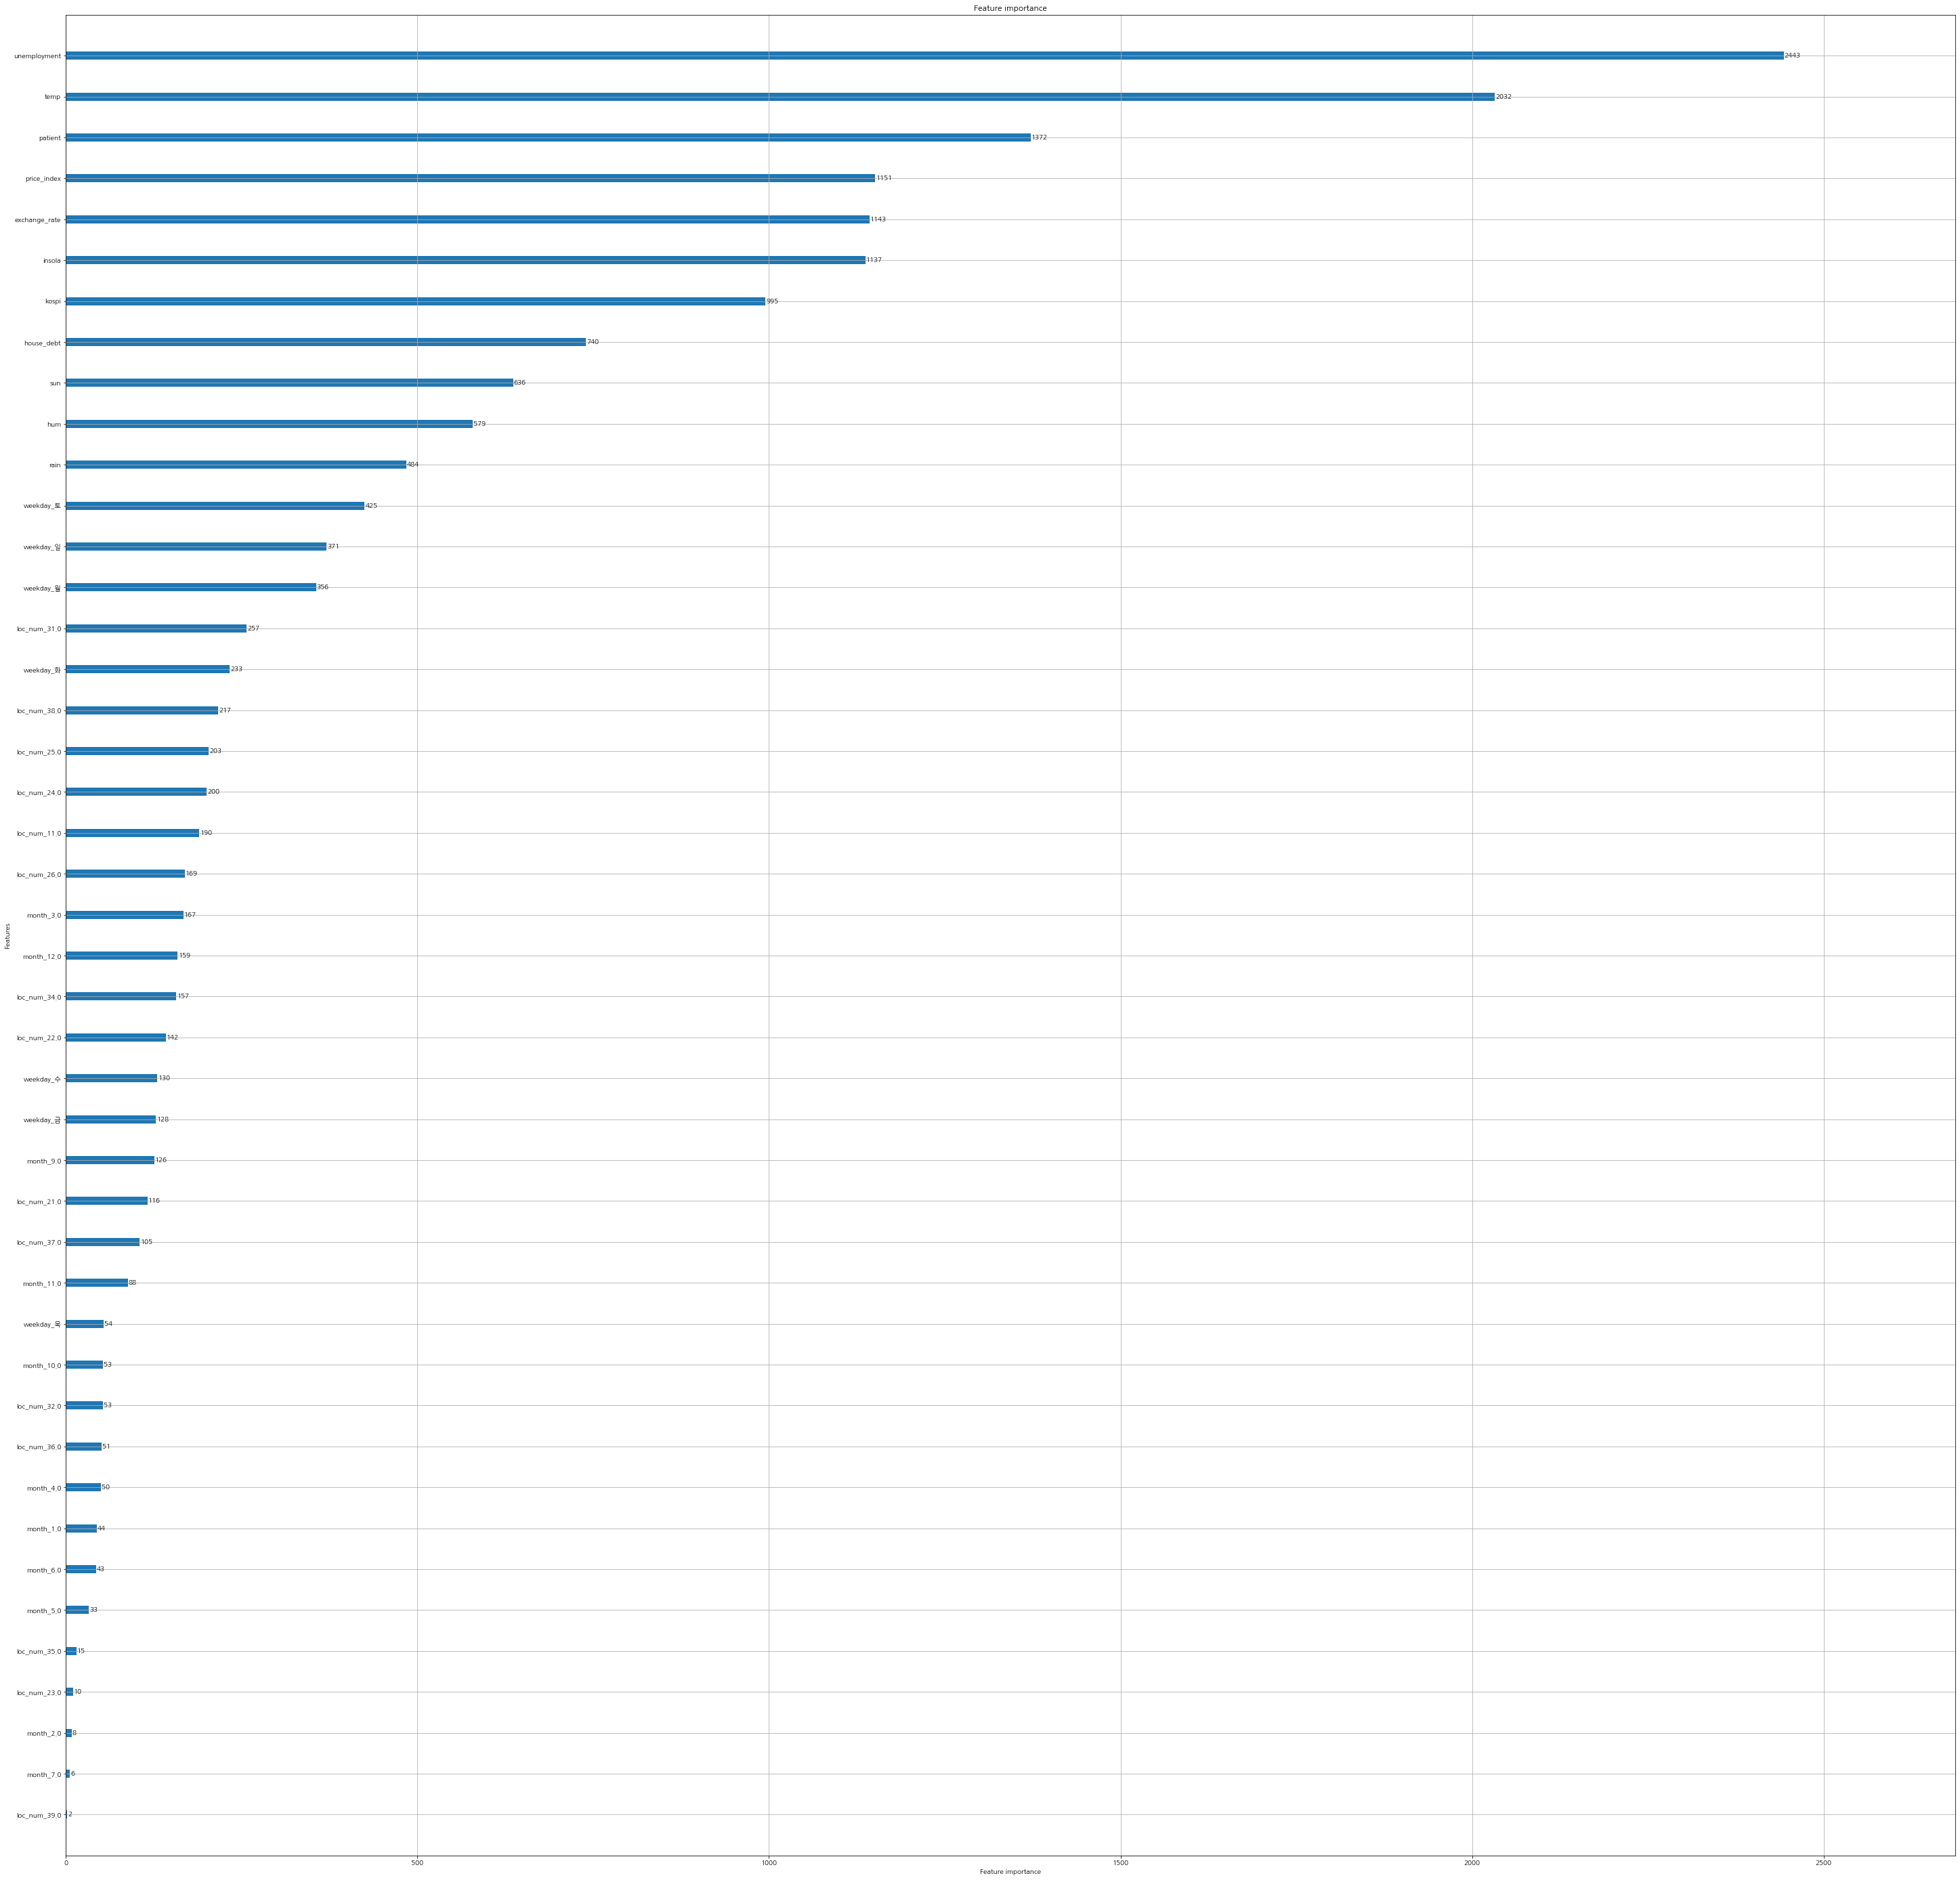

In [391]:
fig, ax = plt.subplots(figsize=(50,50))
plot_importance(reg3.best_estimator_, ax = ax)

In [392]:
permuter = PermutationImportance(
    reg3.best_estimator_,
    scoring='r2',
    n_iter=5, 
    random_state=2)

perm = permuter.fit(X_test3, y_test3)

In [394]:
eli5.show_weights(perm, top = 20, feature_names = X_test3.columns.to_list())

Weight,Feature
1.0950 ± 0.0126,unemployment
0.0257 ± 0.0018,loc_num_11.0
0.0186 ± 0.0014,loc_num_31.0
0.0109 ± 0.0016,temp
0.0086 ± 0.0016,house_debt
0.0059 ± 0.0026,weekday_토
0.0055 ± 0.0027,insola
0.0052 ± 0.0019,weekday_월
0.0050 ± 0.0008,patient
0.0045 ± 0.0012,price_index


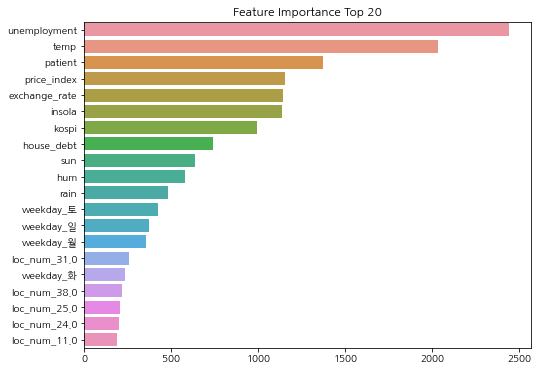

In [395]:
ft_importance_values = reg3.best_estimator_.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환

ft_series = pd.Series(ft_importance_values, index = X_train3.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)

plt.show()

# feature별 영향력 분석

> 특정 feature들만 남겨놓고 튜닝이 되지 않은 머신러닝 모델로 평가해봄

In [397]:
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((32312, 35), (13848, 35), (32312,), (13848,))

In [400]:
rf_reg = RandomForestRegressor()
xgb_reg = XGBRegressor()
lgb_reg = LGBMRegressor()

In [401]:
rf_reg.fit(X_train2, y_train2)
pred = rf_reg.predict(X_test2)

print('accuracy: ', rf_reg.score(X_train2, y_train2))
print('r2score: ',r2_score(y_test2, pred))
print('MAE:',mean_absolute_error(y_test2, pred))
print('MSE: ',mean_squared_error(y_test2, pred))
print('MSLE: ',mean_squared_log_error(y_test2, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test2, pred)))

accuracy:  0.9478611167428196
r2score:  0.6221879203906491
MAE: 1.162319468515309
MSE:  2.618076978625072
MSLE:  0.130112186456474
RMSLE 0.3607106686202586


In [402]:
xgb_reg.fit(X_train2, y_train2)
pred = xgb_reg.predict(X_test2)

print('accuracy: ', xgb_reg.score(X_train2, y_train2))
print('r2score: ',r2_score(y_test2, pred))
print('MAE:',mean_absolute_error(y_test2, pred))
print('MSE: ',mean_squared_error(y_test2, pred))
print('MSLE: ',mean_squared_log_error(y_test2, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test2, pred)))

accuracy:  0.7735972592246847
r2score:  0.6190864550370381
MAE: 1.156398287539035
MSE:  2.639568814065295
MSLE:  0.12783303613435326
RMSLE 0.35753746116225815


In [403]:
lgb_reg.fit(X_train2, y_train2)
pred = lgb_reg.predict(X_test2)

print('accuracy: ', lgb_reg.score(X_train2, y_train2))
print('r2score: ',r2_score(y_test2, pred))
print('MAE:',mean_absolute_error(y_test2, pred))
print('MSE: ',mean_squared_error(y_test2, pred))
print('MSLE: ',mean_squared_log_error(y_test2, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test2, pred)))

accuracy:  0.7098990491600303
r2score:  0.6415178855851829
MAE: 1.1331592480509667
MSE:  2.4841285433983336
MSLE:  0.12195577842296138
RMSLE 0.34922167519064645


## 기후 features

In [496]:
target = 'suicide'
features = ['rain', 'temp', 'hum', 'sun', 'insola' ]

X_df4 = df[features]
y_df4 = df[target]

X_df4.shape, y_df4.shape

((46160, 5), (46160,))

In [497]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_df4, y_df4, test_size=0.3, random_state=47 )
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((32312, 5), (13848, 5), (32312,), (13848,))

In [498]:
lgb_reg.fit(X_train4, y_train4)
pred = lgb_reg.predict(X_test4)

print('accuracy: ', lgb_reg.score(X_train4, y_train4))
print('r2score: ',r2_score(y_test4, pred))
print('MAE:',mean_absolute_error(y_test4, pred))
print('MSE: ',mean_squared_error(y_test4, pred))
print('MSLE: ',mean_squared_log_error(y_test4, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test4, pred)))

accuracy:  0.12678323667096636
r2score:  0.04836524278891874
MAE: 1.8102856572075194
MSE:  6.594424012302354
MSLE:  0.28053749804228173
RMSLE 0.5296579066173578


> 기후 features만으로는 모델이 전혀 예측하지 못함

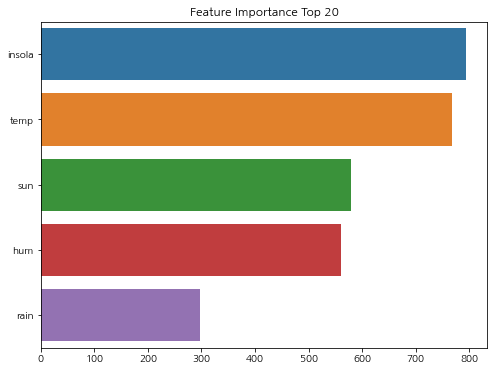

In [499]:
ft_importance_values = lgb_reg.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환

ft_series = pd.Series(ft_importance_values, index = X_train4.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)

plt.show()

## 금융 features

In [500]:
target = 'suicide'
features = ['exchange_rate','kospi', 'price_index', 'house_debt']

X_df4 = df[features]
y_df4 = df[target]

X_df4.shape, y_df4.shape

((46160, 4), (46160,))

In [501]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_df4, y_df4, test_size=0.3, random_state=47 )
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((32312, 4), (13848, 4), (32312,), (13848,))

In [502]:
lgb_reg.fit(X_train4, y_train4)
pred = lgb_reg.predict(X_test4)

print('accuracy: ', lgb_reg.score(X_train4, y_train4))
print('r2score: ',r2_score(y_test4, pred))
print('MAE:',mean_absolute_error(y_test4, pred))
print('MSE: ',mean_squared_error(y_test4, pred))
print('MSLE: ',mean_squared_log_error(y_test4, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test4, pred)))

accuracy:  0.031392591735530884
r2score:  -0.012917571855878274
MAE: 1.865152728199853
MSE:  7.019087846165964
MSLE:  0.2991089706912571
RMSLE 0.5469085578881145


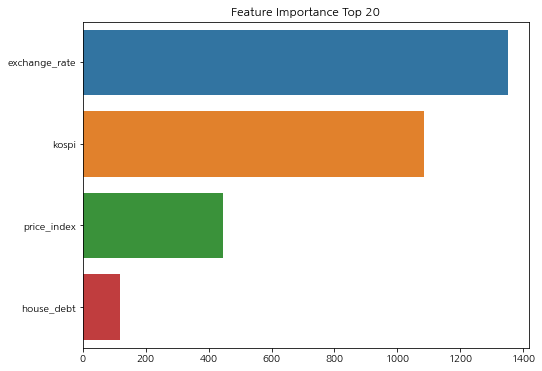

In [503]:
ft_importance_values = lgb_reg.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환

ft_series = pd.Series(ft_importance_values, index = X_train4.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)

plt.show()

> 전혀 예측하지 못함

## 지역코드

In [469]:
target = 'suicide'
features = ['loc_num']

X_df4 = df[features]
y_df4 = df[target]

X_df4.shape, y_df4.shape

((46160, 1), (46160,))

In [470]:
def engeeniring(df):
    df = pd.get_dummies(df, columns = ['loc_num'])
    return df

In [471]:
X_df4 = engeeniring(X_df4)

In [450]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_df4, y_df4, test_size=0.3, random_state=47 )
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((32312, 17), (13848, 17), (32312,), (13848,))

In [459]:
lgb_reg.fit(X_train4, y_train4)
pred = lgb_reg.predict(X_test4)

print('accuracy: ', lgb_reg.score(X_train4, y_train4))
print('r2score: ',r2_score(y_test4, pred))
print('MAE:',mean_absolute_error(y_test4, pred))
print('MSE: ',mean_squared_error(y_test4, pred))
print('MSLE: ',mean_squared_log_error(y_test4, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test4, pred)))

accuracy:  0.6175241966662051
r2score:  0.6117288180604863
MAE: 1.161660868217199
MSE:  2.6905541081440547
MSLE:  0.12679722653157177
RMSLE 0.35608598193634605


> 지역만으로도 어느 정도 예측

## 실업자 수

In [460]:
target = 'suicide'
features = ['unemployment']

X_df4 = df[features]
y_df4 = df[target]

X_df4.shape, y_df4.shape

((46160, 1), (46160,))

In [461]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_df4, y_df4, test_size=0.3, random_state=47 )
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((32312, 1), (13848, 1), (32312,), (13848,))

In [464]:
lgb_reg.fit(X_train4, y_train4)
pred = lgb_reg.predict(X_test4)

print('accuracy: ', lgb_reg.score(X_train4, y_train4))
print('r2score: ',r2_score(y_test4, pred))
print('MAE:',mean_absolute_error(y_test4, pred))
print('MSE: ',mean_squared_error(y_test4, pred))
print('MSLE: ',mean_squared_log_error(y_test4, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test4, pred)))

accuracy:  0.606690389596098
r2score:  0.5899420801919947
MAE: 1.194458469379703
MSE:  2.8415269328134367
MSLE:  0.13436034673411187
RMSLE 0.3665519700316885


> 지역별 실업자 수만으로도 어느 정도 예측

## date features

In [504]:
target = 'suicide'
features = ['year', 'month', 'day', 'weekday']

X_df4 = df[features]
y_df4 = df[target]

X_df4.shape, y_df4.shape

((46160, 4), (46160,))

In [505]:
def engeeniring(df):
    df = pd.get_dummies(df, columns = ['year', 'month', 'day', 'weekday'])
    return df

In [506]:
X_df4 = engeeniring(X_df4)

In [507]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_df4, y_df4, test_size=0.3, random_state=47 )
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((32312, 60), (13848, 60), (32312,), (13848,))

In [508]:
lgb_reg.fit(X_train4, y_train4)
pred = lgb_reg.predict(X_test4)

print('accuracy: ', lgb_reg.score(X_train4, y_train4))
print('r2score: ',r2_score(y_test4, pred))
print('MAE:',mean_absolute_error(y_test4, pred))
print('MSE: ',mean_squared_error(y_test4, pred))
print('MSLE: ',mean_squared_log_error(y_test4, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test4, pred)))

accuracy:  0.032827927557337766
r2score:  -0.009168020482295258
MAE: 1.8632276870198294
MSE:  6.993105050323386
MSLE:  0.2983450977295124
RMSLE 0.5462097561647105


> 전혀 예측하지 못함

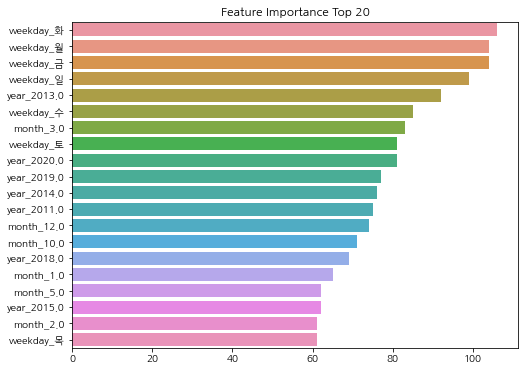

In [509]:
ft_importance_values = lgb_reg.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환

ft_series = pd.Series(ft_importance_values, index = X_train4.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)

plt.show()

## 우울증

In [510]:
target = 'suicide'
features = ['patient']

X_df4 = df[features]
y_df4 = df[target]

X_df4.shape, y_df4.shape

((46160, 1), (46160,))

In [513]:
def engeeniring(df):
    df.fillna(df.patient.mean(), inplace= True)
    return df

In [514]:
X_df4 = engeeniring(X_df4)

In [515]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_df4, y_df4, test_size=0.3, random_state=47 )
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((32312, 1), (13848, 1), (32312,), (13848,))

In [516]:
lgb_reg.fit(X_train4, y_train4)
pred = lgb_reg.predict(X_test4)

print('accuracy: ', lgb_reg.score(X_train4, y_train4))
print('r2score: ',r2_score(y_test4, pred))
print('MAE:',mean_absolute_error(y_test4, pred))
print('MSE: ',mean_squared_error(y_test4, pred))
print('MSLE: ',mean_squared_log_error(y_test4, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test4, pred)))

accuracy:  0.45434693609969345
r2score:  0.4457387351920823
MAE: 1.3447047359961288
MSE:  3.840794765052582
MSLE:  0.16963730435908567
RMSLE 0.411870494644962


> 어느 정도 설명

## feature 조합

> 예측에 적지 않은 영향을 주었던 feature들만 꼽아 모델링을 해봄(지역, 기온, 일사량, 환율, 우울증 환자 수, 실업자 수)

In [518]:
target = 'suicide'
features = ['loc_num', 'temp', 'insola', 'exchange_rate', 'patient', 'unemployment']

X_fin = df[features]
y_fin = df[target]

X_fin.shape, y_fin.shape

((46160, 6), (46160,))

In [519]:
def engeeniring(df):
    df = pd.get_dummies(df, columns = ['loc_num'])
    df.fillna(df.patient.mean(), inplace= True)
    return df

In [ ]:
X_fin = engeeniring(X_fin)

In [520]:
X_train, X_test, y_train, y_test = train_test_split(X_fin, y_fin, test_size=0.3, random_state=47 )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32312, 6), (13848, 6), (32312,), (13848,))

In [521]:
lgb_reg.fit(X_train, y_train)
pred = lgb_reg.predict(X_test)

print('accuracy: ', lgb_reg.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.6893600851555473
r2score:  0.6275121956982318
MAE: 1.1451424443427574
MSE:  2.581182015856658
MSLE:  0.12412745540736819
RMSLE 0.352317265270052


In [523]:
params = { 
    'n_estimators': [800, 1000, 1200], 
    'max_depth': [4, 5, 6, 7, 8, 9], 
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [None, 5 , 7, 9, 10],
    'reg_lambda' : [None, 5, 7, 9, 10]
} 

reg = RandomizedSearchCV(
    LGBMRegressor(learning_rate = 0.01, n_jobs = -1),
    params, 
    random_state=42,
    cv=5,
    verbose=3,
    n_iter=100,
    scoring='r2'
)

reg.fit(X_train, y_train)

pred = reg.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.630 total time=   0.7s
[CV 2/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.640 total time=   0.6s
[CV 3/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.628 total time=   0.6s
[CV 4/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.629 total time=   0.6s
[CV 5/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=1.0;, score=0.633 total time=   0.6s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=1000, reg_alpha=10, reg_lambda=10, subsample=1.0;, score=0.631 total time=   0.6s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=1000, reg_alpha=10, reg_lamb

[CV 3/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.624 total time=   0.9s
[CV 4/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.628 total time=   0.9s
[CV 5/5] END colsample_bytree=1.0, max_depth=7, n_estimators=800, reg_alpha=5, reg_lambda=10, subsample=1.0;, score=0.631 total time=   1.0s
[CV 1/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.630 total time=   0.9s
[CV 2/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.637 total time=   0.9s
[CV 3/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.625 total time=   0.9s
[CV 4/5] END colsample_bytree=0.8, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.627 total time=   0.9s
[CV 5/5] END cols

[CV 1/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.631 total time=   0.9s
[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.639 total time=   0.9s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.624 total time=   0.9s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.629 total time=   0.9s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=800, reg_alpha=7, reg_lambda=9, subsample=0.9;, score=0.632 total time=   0.9s
[CV 1/5] END colsample_bytree=1.0, max_depth=5, n_estimators=800, reg_alpha=9, reg_lambda=9, subsample=1.0;, score=0.631 total time=   0.9s
[CV 2/5] END colsample_bytree=1.0, max_depth=5, n_estimators=800, reg_alpha=9, reg_lambda=9, subsample=1.0;, score=0.638 total time=   0.8s
[CV 3/5] END colsamp

[CV 4/5] END colsample_bytree=1.0, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.627 total time=   1.0s
[CV 5/5] END colsample_bytree=1.0, max_depth=9, n_estimators=800, reg_alpha=5, reg_lambda=9, subsample=0.8;, score=0.632 total time=   0.9s
[CV 1/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.630 total time=   1.1s
[CV 2/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.638 total time=   1.1s
[CV 3/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.622 total time=   1.1s
[CV 4/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.628 total time=   1.0s
[CV 5/5] END colsample_bytree=0.9, max_depth=7, n_estimators=1000, reg_alpha=9, reg_lambda=None, subsample=1.0;, score=0.630 total time=   1.1s


[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.637 total time=   1.4s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.623 total time=   1.3s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.627 total time=   1.5s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1200, reg_alpha=None, reg_lambda=5, subsample=0.9;, score=0.629 total time=   1.4s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.631 total time=   0.7s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.639 total time=   0.7s
[CV 3/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.628 total time=   0.6s
[CV 

[CV 5/5] END colsample_bytree=1.0, max_depth=8, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.8;, score=0.630 total time=   1.1s
[CV 1/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.628 total time=   1.5s
[CV 2/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.637 total time=   1.5s
[CV 3/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.624 total time=   1.5s
[CV 4/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.627 total time=   1.4s
[CV 5/5] END colsample_bytree=1.0, max_depth=6, n_estimators=1200, reg_alpha=5, reg_lambda=7, subsample=0.9;, score=0.630 total time=   1.4s
[CV 1/5] END colsample_bytree=1.0, max_depth=8, n_estimators=800, reg_alpha=7, reg_lambda=5, subsample=0.9;, score=0.630 total time=   1.1s
[CV 2/5] END co

[CV 3/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.624 total time=   1.5s
[CV 4/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.625 total time=   1.6s
[CV 5/5] END colsample_bytree=0.8, max_depth=8, n_estimators=1000, reg_alpha=None, reg_lambda=None, subsample=0.9;, score=0.629 total time=   1.2s
[CV 1/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.631 total time=   0.5s
[CV 2/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.639 total time=   0.5s
[CV 3/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.628 total time=   0.5s
[CV 4/5] END colsample_bytree=0.9, max_depth=4, n_estimators=800, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.630 total time=   0.5s

[CV 1/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.627 total time=   1.1s
[CV 2/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.636 total time=   1.1s
[CV 3/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.623 total time=   1.1s
[CV 4/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.626 total time=   1.1s
[CV 5/5] END colsample_bytree=1.0, max_depth=7, n_estimators=1200, reg_alpha=5, reg_lambda=5, subsample=0.9;, score=0.628 total time=   1.1s
[CV 1/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=10, reg_lambda=9, subsample=0.9;, score=0.631 total time=   0.4s
[CV 2/5] END colsample_bytree=0.8, max_depth=4, n_estimators=800, reg_alpha=10, reg_lambda=9, subsample=0.9;, score=0.639 total time=   0.4s
[CV 3/5] END 

[CV 4/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.629 total time=   0.6s
[CV 5/5] END colsample_bytree=1.0, max_depth=4, n_estimators=1000, reg_alpha=9, reg_lambda=5, subsample=0.8;, score=0.633 total time=   0.6s
[CV 1/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.630 total time=   0.9s
[CV 2/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.639 total time=   0.9s
[CV 3/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.624 total time=   1.0s
[CV 4/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.628 total time=   0.9s
[CV 5/5] END colsample_bytree=0.9, max_depth=6, n_estimators=1000, reg_alpha=10, reg_lambda=7, subsample=0.8;, score=0.631 total time=   0.9s
[CV 1/5]

In [527]:
print(reg.best_score_)
print(reg.best_params_)
print(reg.best_estimator_)

0.6323496093337757
{'subsample': 0.9, 'reg_lambda': 7, 'reg_alpha': 10, 'n_estimators': 800, 'max_depth': 4, 'colsample_bytree': 0.9}
LGBMRegressor(colsample_bytree=0.9, learning_rate=0.01, max_depth=4,
              n_estimators=800, reg_alpha=10, reg_lambda=7, subsample=0.9)


In [524]:
print('accuracy: ', reg.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.6485825325248629
r2score:  0.6319913605306762
MAE: 1.1426883446656113
MSE:  2.5501433091445413
MSLE:  0.12386743817822124
RMSLE 0.3519480617622737


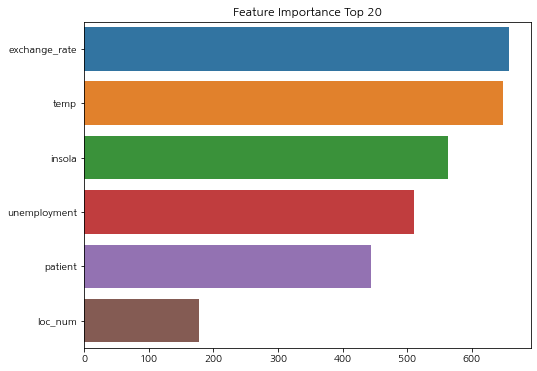

In [532]:
ft_importance_values = lgb_reg.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환

ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)

plt.show()

> 환율이 1순위를 차지하는 등 결과에 다소 의구심 듦

# 최종 모델링

> date 관련 features 제거 뒤 모델링

In [535]:
target = 'suicide'
features = ['loc_num', 'weekday', 'rain', 'temp', 'hum', 'sun', 'insola', 'exchange_rate','kospi', 'price_index', 'house_debt', 'patient', 'unemployment']

X_df = df[features]
y_df = df[target]

X_df.shape, y_df.shape

((46160, 13), (46160,))

In [536]:
def engeeniring(df):
    df = pd.get_dummies(df, columns = ['loc_num', 'weekday'])
    df.patient.fillna(df.patient.mean(), inplace=True)
    return df

In [537]:
X_df = engeeniring(X_df)
X_df

,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,...,loc_num_37.0,loc_num_38.0,loc_num_39.0,weekday_금,weekday_목,weekday_수,weekday_월,weekday_일,weekday_토,weekday_화
0,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
1,0.0,-2.0,46.0,6.1,9.85,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
2,0.9,-3.3,55.0,3.7,8.44,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
3,0.0,-7.5,64.0,8.4,9.26,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
4,0.4,-3.5,70.0,8.3,8.85,1124.65,2051.00,88.288,806.4,18932.348543,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46155,0.0,-8.7,57.0,6.3,8.68,1084.47,2873.47,100.330,1631.5,80473.000000,...,0,0,0,0,1,0,0,0,0,0
46156,0.0,-9.4,63.0,6.1,11.02,1084.47,2873.47,100.330,1631.5,11591.000000,...,0,0,0,0,1,0,0,0,0,0
46157,0.4,-7.6,75.0,6.5,9.67,1084.47,2873.47,100.330,1631.5,15193.000000,...,0,0,0,0,1,0,0,0,0,0
46158,0.0,-6.6,48.0,8.7,11.22,1084.47,2873.47,100.330,1631.5,14348.000000,...,1,0,0,0,1,0,0,0,0,0


In [538]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=47 )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32312, 35), (13848, 35), (32312,), (13848,))

In [618]:
reg = LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=4,
                    n_estimators=1000, reg_alpha=3, reg_lambda=5, subsample=0.9)

reg.fit(X_train, y_train)
pred = reg.predict(X_test)

## LGBM회귀모델의 성능 평가

In [619]:
print('accuracy: ', reg.score(X_train, y_train))
print('r2score: ',r2_score(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('MSLE: ',mean_squared_log_error(y_test, pred))
print('RMSLE', np.sqrt(mean_squared_log_error(y_test, pred)))

accuracy:  0.66729453815101
r2score:  0.6454682145730184
MAE: 1.1285417511852376
MSE:  2.456754444106057
MSLE:  0.12141958069598982
RMSLE 0.3484531255362618


## feature importance, permutation importance

>feature importance

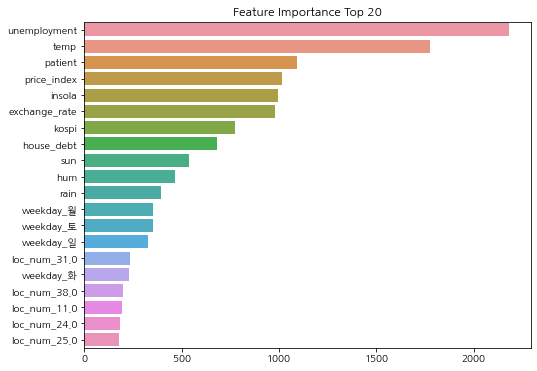

In [589]:
ft_importance_values = reg.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환

ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)

plt.show()

>permutation importance

In [591]:
permuter = PermutationImportance(
    reg,
    scoring='r2',
    n_iter=5, 
    random_state=2)

perm = permuter.fit(X_test, y_test)
eli5.show_weights(perm, top = 20, feature_names = X_test.columns.to_list())

Weight,Feature
1.0270 ± 0.0234,unemployment
0.0240 ± 0.0026,loc_num_31.0
0.0200 ± 0.0010,loc_num_11.0
0.0115 ± 0.0014,temp
0.0071 ± 0.0013,house_debt
0.0062 ± 0.0014,weekday_토
0.0059 ± 0.0019,insola
0.0053 ± 0.0020,weekday_월
0.0051 ± 0.0020,price_index
0.0050 ± 0.0005,patient


## shap value

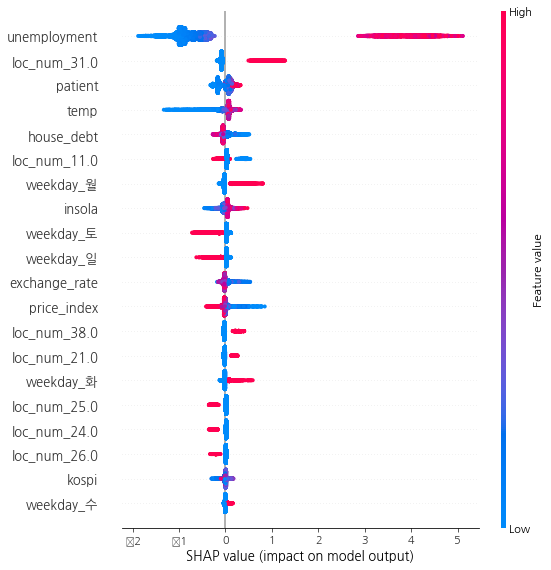

In [668]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [655]:
y = y_test.iloc[[222]]
y

29198    10.0
Name: suicide, dtype: float64

In [656]:
pd.set_option('display.max_columns', 100)
row = X_test.iloc[[222]]
row

,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,unemployment,loc_num_11.0,loc_num_21.0,loc_num_22.0,loc_num_23.0,loc_num_24.0,loc_num_25.0,loc_num_26.0,loc_num_29.0,loc_num_31.0,loc_num_32.0,loc_num_33.0,loc_num_34.0,loc_num_35.0,loc_num_36.0,loc_num_37.0,loc_num_38.0,loc_num_39.0,weekday_금,weekday_목,weekday_수,weekday_월,weekday_일,weekday_토,weekday_화
29198,0.0,17.1,68.0,11.3,20.09,1137.88,2205.44,97.442,1313.0,53872.0,324.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


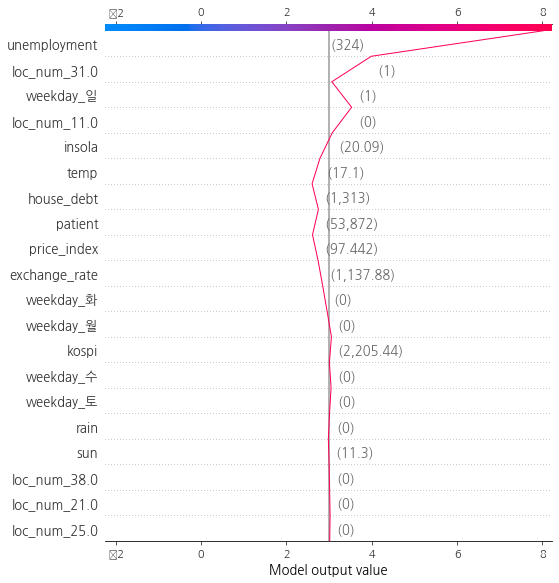

In [657]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.decision_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [658]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [659]:
y = y_test.iloc[[531]]
row = X_test.iloc[[531]]
print(y)
row

1568    3.0
Name: suicide, dtype: float64


,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,unemployment,loc_num_11.0,loc_num_21.0,loc_num_22.0,loc_num_23.0,loc_num_24.0,loc_num_25.0,loc_num_26.0,loc_num_29.0,loc_num_31.0,loc_num_32.0,loc_num_33.0,loc_num_34.0,loc_num_35.0,loc_num_36.0,loc_num_37.0,loc_num_38.0,loc_num_39.0,weekday_금,weekday_목,weekday_수,weekday_월,weekday_일,weekday_토,weekday_화
1568,0.0,14.6,55.0,9.9,24.0,1076.75,2180.64,89.497,826.9,18932.348543,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


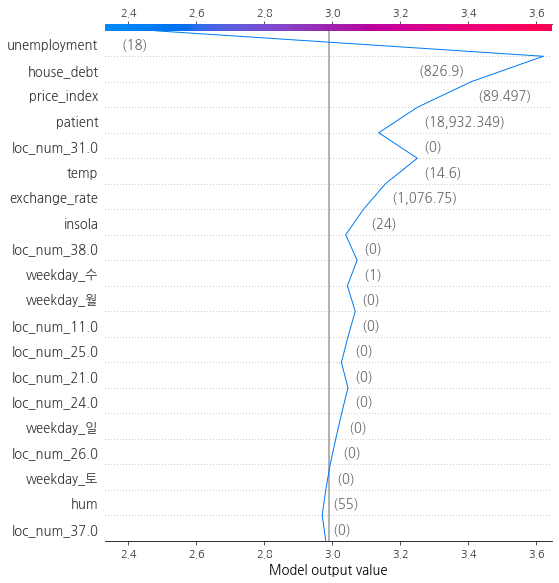

In [660]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.decision_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [662]:
y = y_test.iloc[[9764]]
row = X_test.iloc[[9764]]
print(y)
row

14992    23.0
Name: suicide, dtype: float64


,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,unemployment,loc_num_11.0,loc_num_21.0,loc_num_22.0,loc_num_23.0,loc_num_24.0,loc_num_25.0,loc_num_26.0,loc_num_29.0,loc_num_31.0,loc_num_32.0,loc_num_33.0,loc_num_34.0,loc_num_35.0,loc_num_36.0,loc_num_37.0,loc_num_38.0,loc_num_39.0,weekday_금,weekday_목,weekday_수,weekday_월,weekday_일,weekday_토,weekday_화
14992,0.0,8.4,71.0,0.3,6.69,1070.68,1937.68,94.153,965.3,46745.0,242.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


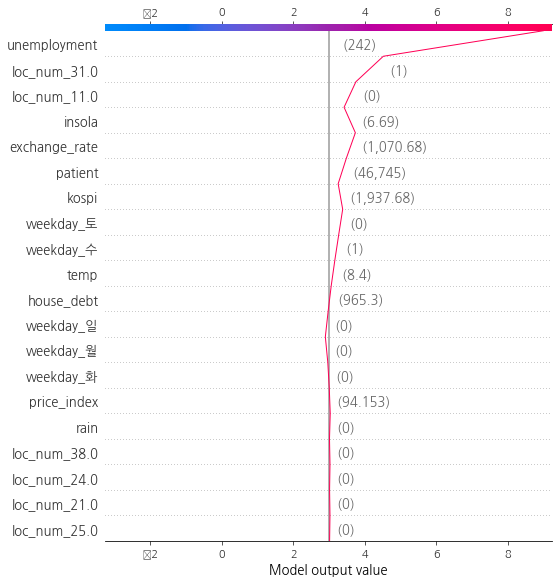

In [663]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.decision_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [664]:
y = y_test.iloc[[1]]
row = X_test.iloc[[1]]
print(y)
row

1649    11.0
Name: suicide, dtype: float64


,rain,temp,hum,sun,insola,exchange_rate,kospi,price_index,house_debt,patient,unemployment,loc_num_11.0,loc_num_21.0,loc_num_22.0,loc_num_23.0,loc_num_24.0,loc_num_25.0,loc_num_26.0,loc_num_29.0,loc_num_31.0,loc_num_32.0,loc_num_33.0,loc_num_34.0,loc_num_35.0,loc_num_36.0,loc_num_37.0,loc_num_38.0,loc_num_39.0,weekday_금,weekday_목,weekday_수,weekday_월,weekday_일,weekday_토,weekday_화
1649,18.0,17.2,77.0,0.3,7.34,1076.5,2166.63,89.497,826.9,18932.348543,190.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


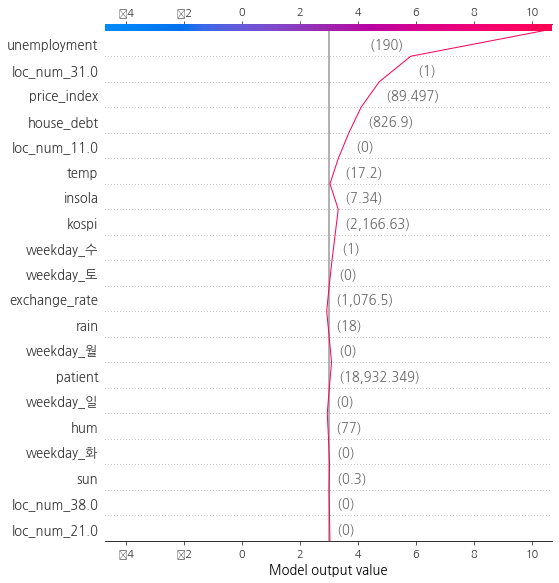

In [665]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.decision_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [615]:
y_test.reset_index()

,index,suicide
0,45499,1.0
1,1649,11.0
2,9092,1.0
3,30138,8.0
4,40584,3.0
...,...,...
13843,30937,1.0
13844,941,3.0
13845,12345,2.0
13846,9761,1.0


In [612]:
y_test.reset_index().loc[y_test.reset_index()['index'] == 14992]

,index,suicide
9764,14992,23.0


# 모델 해석

- 자살이 계절적인 영향을 받을 것이라는 세간에 알려진 통념과 달리, date 변수들은 모델에 큰 영향을 끼치지 못했음.
- 자살은 지역 실업자 수에 가장 크게 영향을 받는 것으로 분석됨. SHAP value에 따르면 실업자 수가 많을수록 자살자 수가 커지고, 적을 수록 자살자 수가 적어짐. 적을 때보단 많을 때가 상대적으로 더 큰 영향을 미치는 것으로 보임.당초 인구 규모에 따라 자살자 수가 크게 영향을 받는 것으로 보았으나, 지역 변수(지난 10년간 지역별 인구가 매우 큰 폭으로 변동되지 않을 것이란 전제)보다 실업자 수에 더 민감하게 반응함.
- 지역적으로는 분석 대상 지역이 경기도와 서울인지 여부가 예측에 다소 영향을 미치는 것으로 파악됨. 경기도인 경우 자살자 수 상승 압력, 서울이 아닌 경우 자살자 수 하락 압력으로 작용.
- 날씨 feature에서는 기온의 경우, 기온이 낮아지면 자살자 수가 상대적으로 크게 줄어드는 경향 나타남. 일사량이 높을수록 상승, 낮을수록 하락.
- 요일별로는 토요일, 일요일인 경우 자살자 수 하락 압력, 월요일, 화요일인 경우 자살자 수 상승 압력으로 작용.
- 물가지수, 가계부채는 음의 상관관계, 환율은 양의 상관관계, kospi는 거의 영향을 미치지 못한 것으로 나타남. 추가적인 분석이 있어야 할 것으로 보임.